In this notebook, we test the performance of our best models with an enhanced data set. Therefore, we extracted the same features for RAVDESS as for EmoDB. We will look at the performance of the models with the same chosen features separately on the new data set and as a combined approach. Moreover, we will perform another feature selection with Featurewiz on the combined data set. </br> The notebook run on the bwunicluster with gpu in order to run the best model XGB with gpu and gpu_hist to build the tree.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# packages for models
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# dimensionality reduction
from featurewiz import featurewiz

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval, run_gridsearchCV, load_model, feature_importance

pd.set_option('display.max_columns', None)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [2]:
def missing_cols(features1, features2):
    """
    Function checks whether there are missing features in one of the given feature sets.
    """
    missing_1 = list(set(features2) - set(features1))
    missing_2 = list(set(features1) - set(features2))
    return missing_1 + missing_2

# 1) RAVDESS only
## a) Ravdess with most important features from featurewiz 97

In [3]:
# get most important features (featurewiz 97)
df = pd.read_pickle('../results/df_prep_most_important97.pkl')
feat_most_imp97 = df.columns.to_list()

# load data
df_ravdess = pd.read_pickle('../results/df_prep_numerical_only_all_stats_ravdess.pkl')

# check if there are any features in the saved set of most important features from emodb
mis_cols = list(set(feat_most_imp97) - set(df_ravdess.columns.to_list()))
print(f'{mis_cols} are missing in the Ravdess feature set and are removed from the list.')
for feat in mis_cols:
    feat_most_imp97.remove(feat) 

# select features
df_ravdess_most_imp97 = df_ravdess[feat_most_imp97]

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_ravdess_most_imp97, test_size=0.3)

['f0_avg_change_rate_median'] are missing in the Ravdess feature set and are removed from the list.
A snippet of the data:


rms_min  mfccs5_mean   zcr_max  duration_rising_pitch_max  \
9   -0.420166     0.153849 -0.647578                   0.158822   
570 -0.287216     0.682831  1.195924                  -0.405119   
605 -0.420166    -1.483293 -0.214193                  -0.066754   
891 -0.269415    -0.049600 -1.087431                  -0.517907   
506 -0.369915     0.637284  0.646108                  -1.081849   

     lpccs_local4_min  lfccs9_max       min  energy_median  lfccs0_median  \
9            0.030787    0.256579  0.273609      -0.291271      -0.178899   
570          0.030787    1.264469  0.731975      -0.320252      -1.481432   
605          0.030787   -0.119943 -1.450705      -0.307094       1.748316   
891          0.030787   -0.521108 -0.405330      -0.324794       0.730244   
506          0.030787   -1.037276  0.612296      -0.249701      -0.591614   

     lpccs_global_median  lpc_global_mean  value_falling_energy_max  \
9              -0.481830        -0.837702                  0.101324   
570            -0.553829         0.050570                  0.086708   
605             1.192733         0.898441                  0.094994   
891             0.379350        -1.057679                  0.094875   
506            -0.199777        -0.639638                  0.092281   

     mfccs11_mean    f1_min  lpc_local3_var  lpccs_local0_var  lfccs9_median  \
9       -1.520579 -1.182574       -0.043204          0.010797      -0.305534   
570      0.870001 -1.279738       -0.043408         -0.816758       1.114897   
605     -0.028626  2.036971       -0.043258          0.834181      -1.272509   
891      0.069364 -0.194516       -0.043330          0.284539      -1.272506   
506     -0.116351 -0.282349       -0.043222         -0.503904       0.733801   

     delta_mfccs0_min  value_falling_pitch_iqr  lpc_local1_mean  \
9            0.653929                -0.295491        -0.201473   
570         -0.712724                -0.559407         0.898442   
605         -0.238524                 2.316268        -0.115204   
891          0.823799                 0.944343        -0.416164   
506          0.527495                -0.297571         0.176213   

     f1_avg_change_rate_var  threshold_entropy_var  mfccs3_max   f2_mean  \
9                 -0.477928              -0.602286   -0.761533 -0.565927   
570               -0.179753               0.575176    0.226611 -1.887476   
605               -0.608444              -0.808086   -1.874285  1.958339   
891               -0.020599               0.786339    0.959212 -0.680259   
506               -0.666570               0.883142    0.222437  0.235269   

     lfccs7_var  lfccs9_var  delta_mfccs5_median  mfccs4_max  energy_var  \
9     -0.163687    0.230889             0.098270   -0.585143   -0.946607   
570   -1.045615    1.614128             3.068837    0.370926   -0.518895   
605    1.335342    0.175781             0.098270   -0.567311    0.023286   
891   -0.091586   -0.000677             0.098270    0.743972   -0.657428   
506   -0.515107   -1.199263             0.098270    0.324526    0.825068   

     delta2_mfccs3_min  lpccs_local5_mean  shannon_entropy_mean  \
9             0.631590          -0.030787              0.090543   
570           1.289229          -0.030787             -1.065104   
605           0.491540          -0.030787              0.340607   
891           0.625837          -0.030787              0.479245   
506           0.708738          -0.030787             -0.133645   

     delta2_mfccs5_mean  delta_mfccs4_median   f3_mean  mfccs5_var  \
9              0.043616            -0.187405 -0.494511    0.705769   
570           -0.723085             1.616394 -2.509165    0.319419   
605            0.036443            -0.187405  1.402143   -1.204541   
891            0.036442            -0.187405  0.164084   -0.210955   
506            0.102885            -0.187405 -0.037485    0.044246   

     voiced_var  duration_rising_energy_var  lpc_local4_median    f0_var  \
9      0.073286

There are 739 entries with 96 columns in the training data.
There are 317 entries with 96 columns in the testing data.


### SVM


Evaluation: f1_score
100.00% for the train data
68.51% for the test data

Evaluation: accuracy_score
100.00% for the train data
69.09% for the test data

Evaluation: precision_score
100.00% for the train data
69.33% for the test data

Evaluation: recall_score
100.00% for the train data
68.27% for the test data

Evaluation: confusion_matrix of test predictions


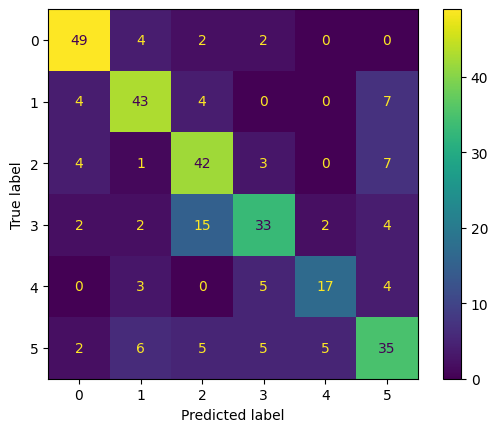


Hard cases for the model:

Label: fear(2)
Hard cases of false positives: ['happiness(3)']

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false positives: ['sadness(5)']



In [4]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_ravdess = SVC().set_params(**svm_best_model.get_params())
svm_ravdess.fit(X_train, y_train)
model_eval(svm_ravdess, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

### Random Forest


Evaluation: f1_score
100.00% for the train data
58.04% for the test data

Evaluation: accuracy_score
100.00% for the train data
58.68% for the test data

Evaluation: precision_score
100.00% for the train data
58.06% for the test data

Evaluation: recall_score
100.00% for the train data
58.69% for the test data

Evaluation: confusion_matrix of test predictions


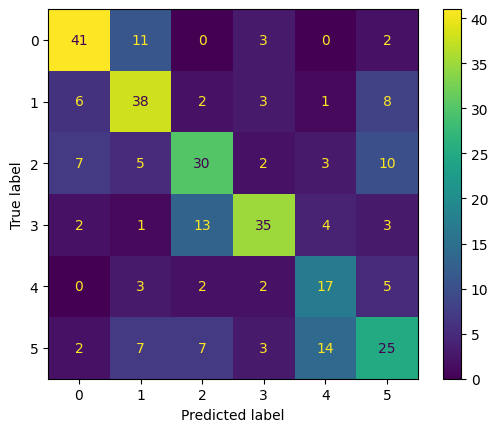


Hard cases for the model:

Label: fear(2)
Hard cases of false positives: ['happiness(3)']

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false positives: ['sadness(5)']

Label: sadness(5)
Hard cases of false negatives: ['neutral(4)']



In [5]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_ravdess = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_ravdess.fit(X_train, y_train)
model_eval(rfc_ravdess, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

### XGB


Evaluation: f1_score
100.00% for the train data
64.12% for the test data

Evaluation: accuracy_score
100.00% for the train data
64.98% for the test data

Evaluation: precision_score
100.00% for the train data
64.74% for the test data

Evaluation: recall_score
100.00% for the train data
63.92% for the test data

Evaluation: confusion_matrix of test predictions


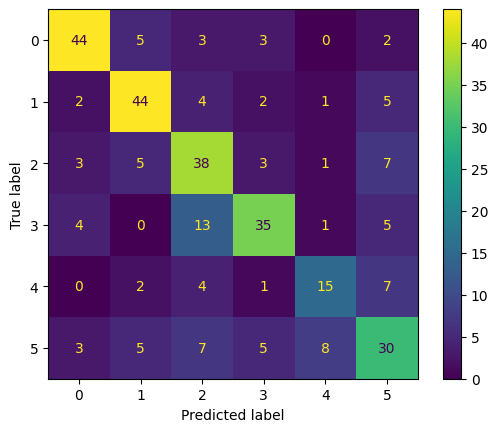


Hard cases for the model:

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false negatives: ['sadness(5)']
Hard cases of false positives: ['sadness(5)']



In [6]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_ravdess = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_ravdess.fit(X_train, y_train)
model_eval(xgb_ravdess, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

## b) RAVDESS own feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (1056, 578)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#############################################

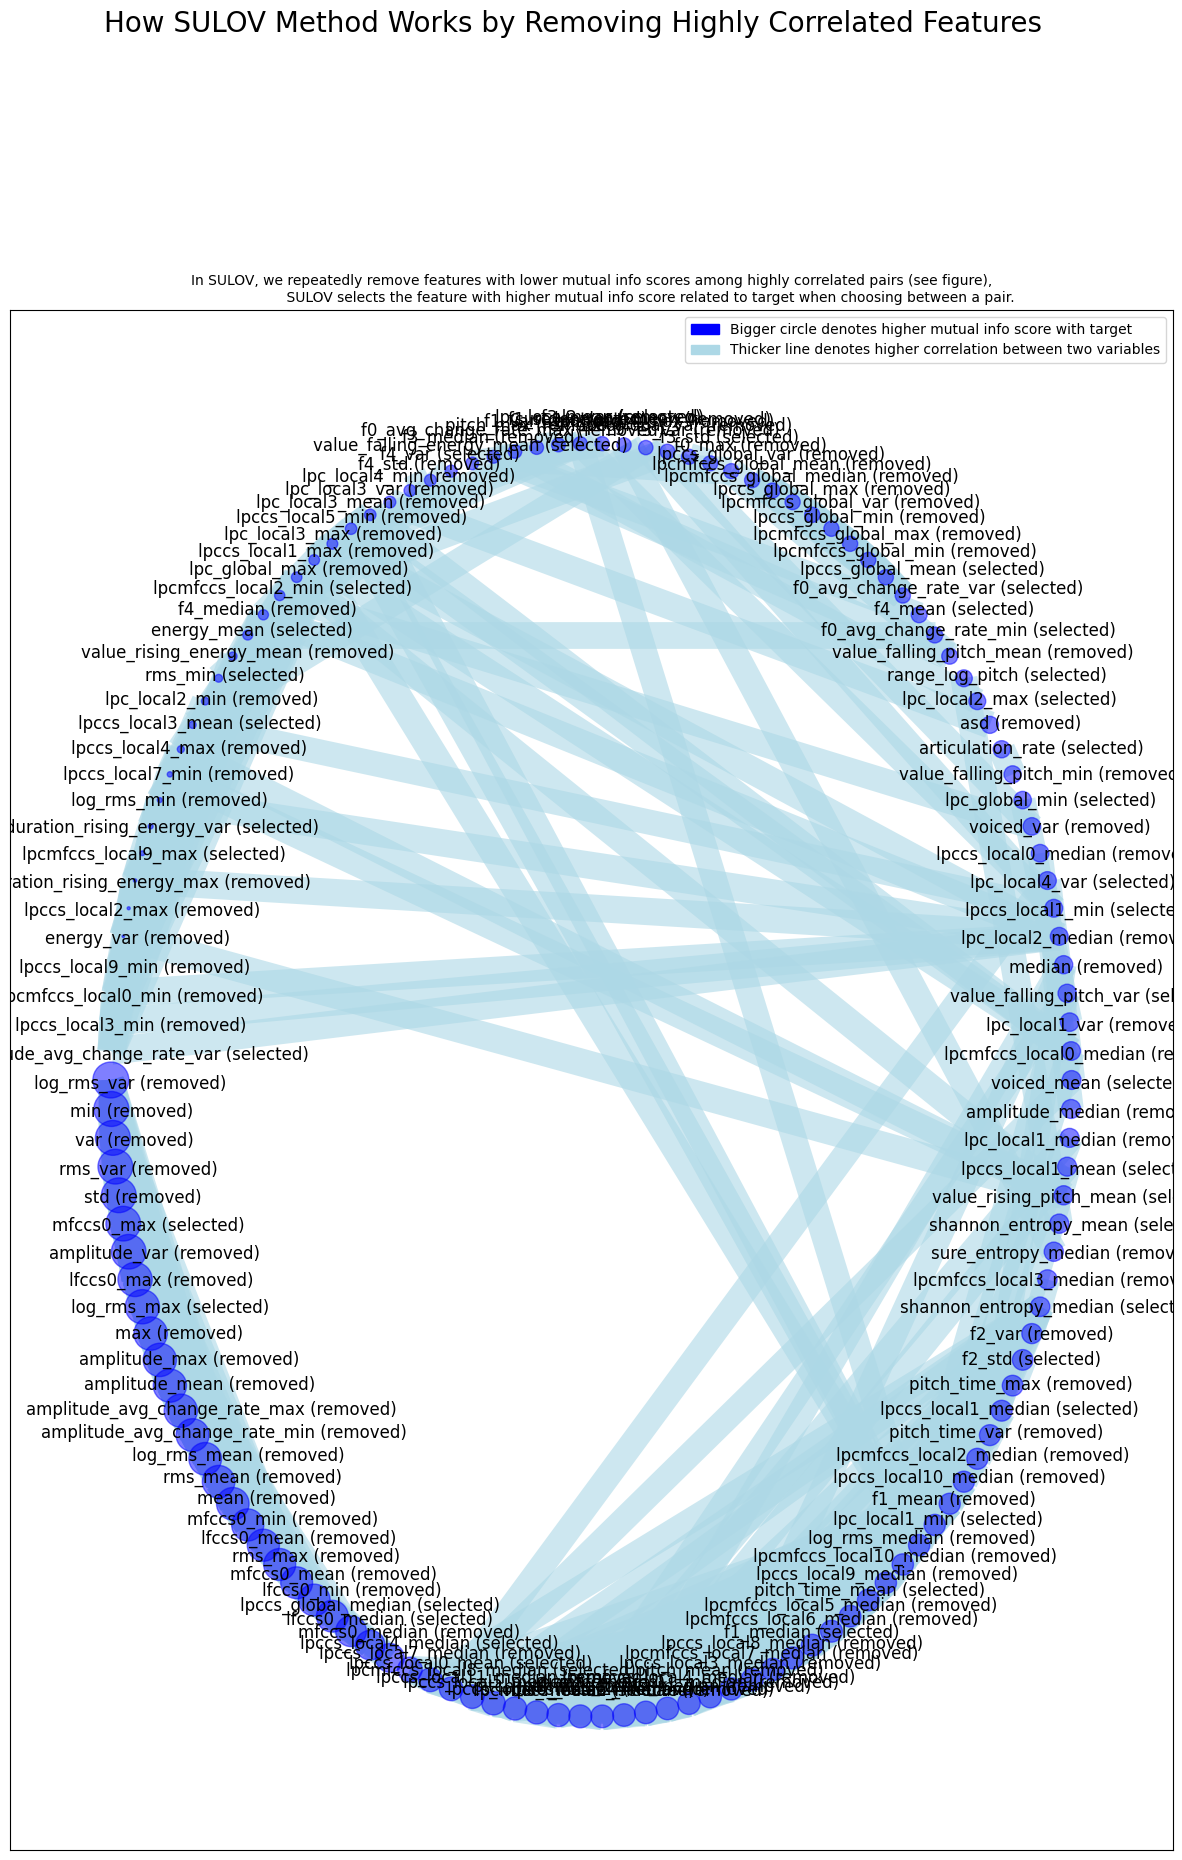

Time taken for SULOV method = 5 seconds
    Adding 0 categorical variables to reduced numeric variables  of 481
Finally 481 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 115 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 19 seconds
            Time taken for regular XGBoost feature selection = 15 seconds
            Time taken for regular XGBoost feature selection = 11 seconds
            Time taken for regular XGBoost feature selection = 8 seconds
            Time taken for regular XGBoost feature selection = 5 sec

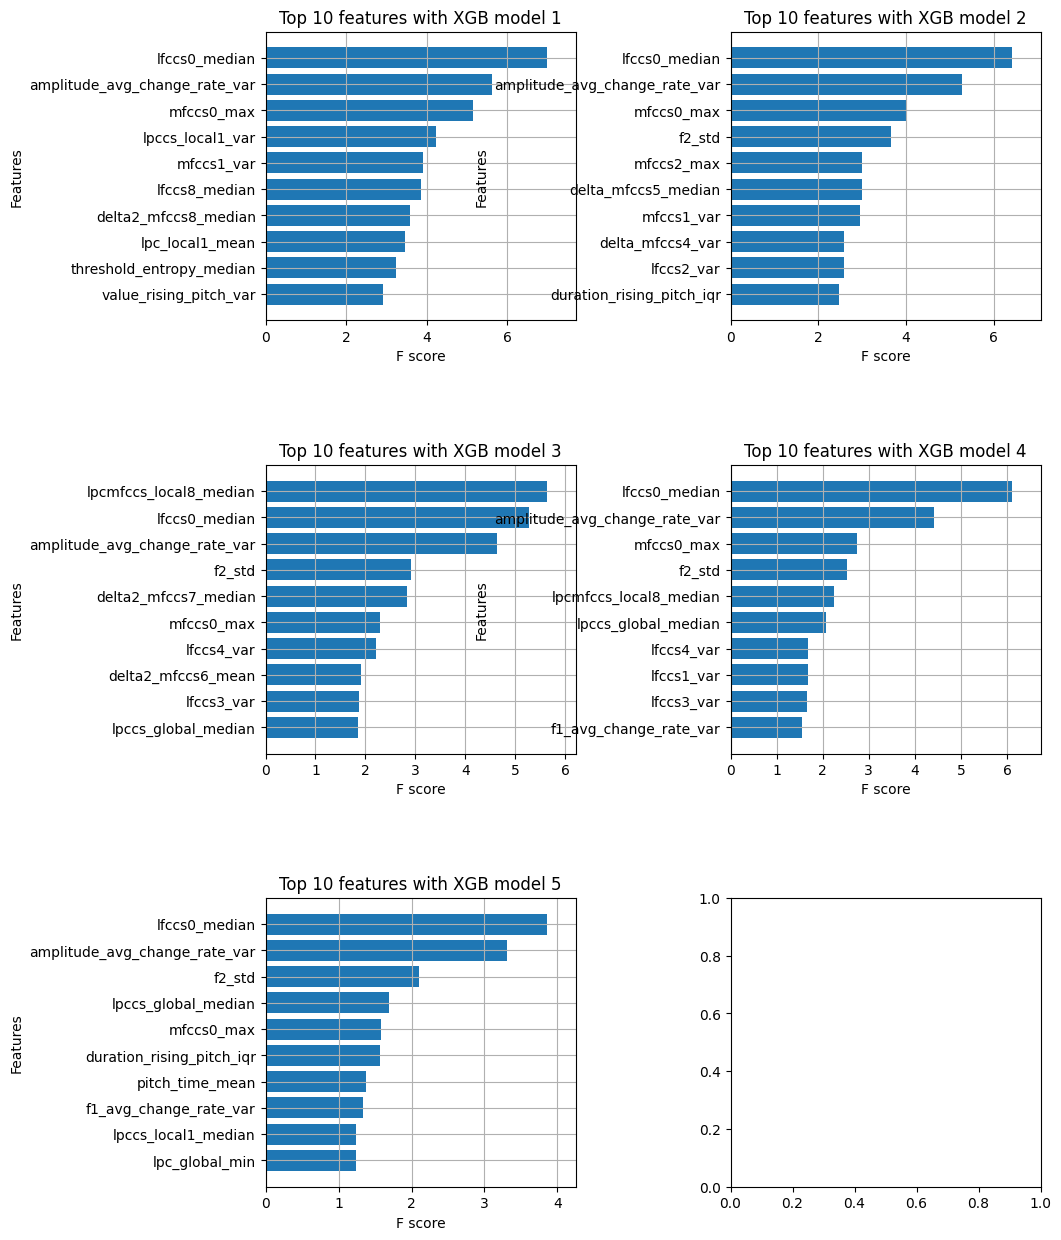

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 235 important features. Too many to print...
Total Time taken for featurewiz selection = 64 seconds
Output contains a list of 235 important features and a train dataframe


In [7]:
# automatic feature selection by using featurewiz package
selected_features_ravdess, df_ravdess_reduced = featurewiz(df_ravdess, 'label', corr_limit=0.9, verbose=2, sep=",", 
                                                           header=0,test_data="", feature_engg="", category_encoders="")

In [8]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_ravdess_reduced, test_size=0.3)

A snippet of the data:


amplitude_avg_change_rate_var    f2_std  mfccs0_max  mfccs2_max  \
9                        -0.345116 -0.910287    0.313787   -0.622456   
570                      -0.443675  0.243770   -1.069141    1.822551   
605                       2.547566 -1.097823    1.327733   -2.679121   
891                      -0.043905 -0.674023    0.423285    1.155091   
506                      -0.436122 -0.261181   -0.795509    0.652876   

     mfccs1_var  lfccs0_median  duration  duration_rising_pitch_iqr  \
9      0.523581      -0.178899 -0.252667                  -0.337728   
570    1.415780      -1.481432 -0.945613                  -0.931690   
605   -2.148868       1.748316 -0.945613                  -0.403724   
891    1.496563       0.730244  0.242304                   0.916191   
506    0.635431      -0.591614  0.044390                  -0.667707   

     lpccs_global_median   f0_mean  lpc_local4_mean  f2_median  \
9              -0.481830 -0.374737         0.388600  -0.269201   
570            -0.553829 -0.911179        -0.760150  -2.437493   
605             1.192733  4.035878         0.676053   1.720228   
891             0.379350 -0.475376        -0.598586  -1.206649   
506            -0.199777 -0.235441        -0.216829   0.648978   

     articulation_rate  delta_mfccs5_min  lfccs2_mean  delta_mfccs4_var  \
9             0.812070         -0.872222     1.363827         -0.919316   
570          -0.344684          0.200847    -0.621452          0.212710   
605           2.280964         -0.112742    -0.948216         -0.646072   
891           1.018634          0.303486     1.481717         -0.339826   
506          -0.544804          0.432869    -1.374017          0.769070   

     lfccs3_var  voiced_mean  duration_rising_pitch_mean  lfccs4_var  \
9     -0.797035    -0.174844                   -0.295021   -0.458904   
570    0.900597    -1.188724                   -0.729889   -0.216650   
605   -0.162368     0.614787                   -0.854137   -1.568545   
891    1.913595     0.280859                    0.113689    0.886268   
506   -0.373585     0.870156                   -0.094032    0.095561   

     lpc_global_mean  lfccs1_var  mfccs4_var  lfccs3_max    f3_std  \
9          -0.837702    1.130653   -0.922169   -0.693371 -1.376544   
570         0.050570   -1.304160   -0.299169    0.611118  2.217610   
605         0.898441   -0.003434    0.079762   -0.993131 -1.157047   
891        -1.057679    0.651765   -0.440149    1.513746 -1.545045   
506        -0.639638    0.300069    0.969085   -0.068050 -0.378114   

     mfccs2_var  mfccs7_var  f2_avg_change_rate_mean  mfccs7_min  \
9     -0.514852    0.437356                -0.298696   -0.630726   
570   -0.726979   -0.624366                 0.360014    0.560881   
605    2.080617    0.954464                 0.283902   -0.313925   
891   -0.678412   -0.684274                 0.426885   -0.598263   
506   -0.608201   -1.454247                 0.636541    1.159755   

     lpc_global_median  lfccs8_median  value_rising_energy_median  \
9            -0.108963       0.652881                    0.668288   
570          -0.531058       1.030791                   -0.200526   
605           0.130273      -4.253986                   -0.176448   
891          -0.659192      -0.846315                   -0.206201   
506          -0.660245       0.513025                   -0.205971   

     range_log_pitch  threshold_entropy_mean  delta2_mfccs3_var  f1_median  \
9           1.202281               -0.518297          -0.944168  -0.485042   
570         1.910064                0.874906          -0.601095  -0.081700   
605         0.531994               -2.034169           0.896936   2.192404   
891         2.138768                1.057698           0.645808  -0.163242   
506        -0.723760                1.448309          -1.338746  -0.708071   

     lfccs4_mean  mfccs10_mean  delta_mfccs6_var  value_rising_pitch_var  \
9       0.801315     -1.671040         -0.910607                0.025799  

There are 739 entries with 235 columns in the training data.
There are 317 entries with 235 columns in the testing data.


### SVM


Evaluation: f1_score
100.00% for the train data
76.42% for the test data

Evaluation: accuracy_score
100.00% for the train data
76.66% for the test data

Evaluation: precision_score
100.00% for the train data
77.04% for the test data

Evaluation: recall_score
100.00% for the train data
76.63% for the test data

Evaluation: confusion_matrix of test predictions


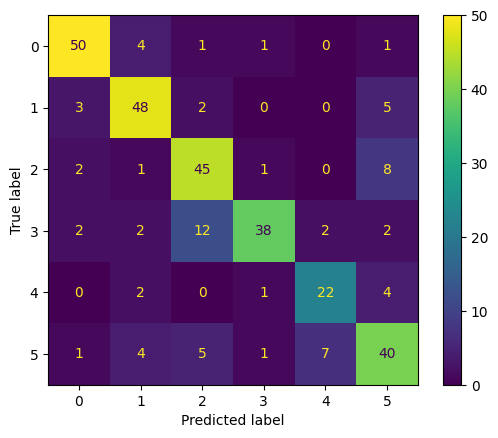


Hard cases for the model:

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false positives: ['sadness(5)']



In [9]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_ravdess_reduced = SVC().set_params(**svm_best_model.get_params())
svm_ravdess_reduced.fit(X_train, y_train)
model_eval(svm_ravdess_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

### Random Forest


Evaluation: f1_score
100.00% for the train data
64.58% for the test data

Evaluation: accuracy_score
100.00% for the train data
64.98% for the test data

Evaluation: precision_score
100.00% for the train data
64.98% for the test data

Evaluation: recall_score
100.00% for the train data
65.67% for the test data

Evaluation: confusion_matrix of test predictions


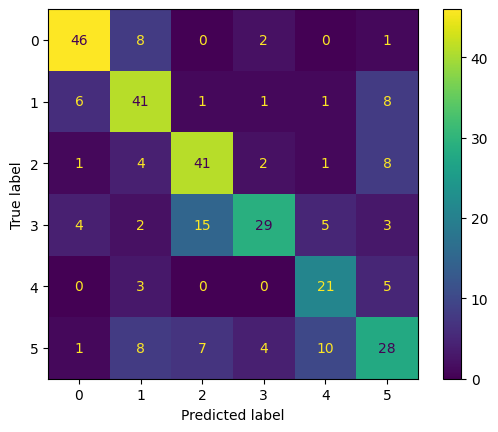


Hard cases for the model:

Label: fear(2)
Hard cases of false positives: ['happiness(3)']

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false positives: ['sadness(5)']



In [10]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_ravdess_reduced = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_ravdess_reduced.fit(X_train, y_train)
model_eval(rfc_ravdess_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

### XGB


Evaluation: f1_score
100.00% for the train data
70.98% for the test data

Evaluation: accuracy_score
100.00% for the train data
71.61% for the test data

Evaluation: precision_score
100.00% for the train data
71.56% for the test data

Evaluation: recall_score
100.00% for the train data
70.87% for the test data

Evaluation: confusion_matrix of test predictions


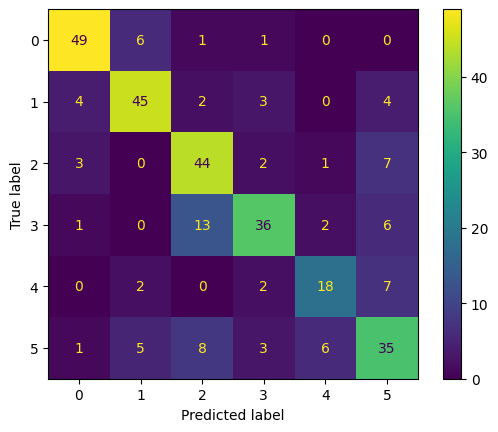


Hard cases for the model:

Label: happiness(3)
Hard cases of false negatives: ['fear(2)']

Label: neutral(4)
Hard cases of false negatives: ['sadness(5)']
Hard cases of false positives: ['sadness(5)']



In [11]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_ravdess_reduced = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_ravdess_reduced.fit(X_train, y_train)
model_eval(xgb_ravdess_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='ravdess')

# 2) EmoDB + RAVDESS
## a) EmoDB + Ravdess with most important features from featurewiz 97

In [12]:
# get most important features (featurewiz 97)
df = pd.read_pickle('../results/df_prep_most_important97.pkl')
feat_most_imp97 = df.columns.to_list() 

# load data
df_emo_rav = pd.read_pickle('../results/df_prep_numerical_only_all_stats_emodb_ravdess.pkl')

# check if there are any features in the saved set of most important features from emodb
mis_cols = list(set(feat_most_imp97) - set(df_emo_rav.columns.to_list()))
print(f'{mis_cols} are missing in the Ravdess feature set and are removed from the list.')
for feat in mis_cols:
    feat_most_imp97.remove(feat)
    
# select features    
df_emo_rav_most_imp97 = df_emo_rav[feat_most_imp97]

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_rav_most_imp97, test_size=0.3)

['f0_avg_change_rate_median'] are missing in the Ravdess feature set and are removed from the list.
A snippet of the data:


rms_min  mfccs5_mean   zcr_max  duration_rising_pitch_max  \
929  -0.389684     1.025865 -1.439237                   0.497759   
332  -0.242957    -3.082846  1.095629                  -1.712043   
590  -0.395241    -0.928347  0.280063                   0.524383   
1057 -0.395241     0.278635  0.416726                   0.471135   
1272 -0.387509     0.483021 -0.791193                   0.737376   

      lpccs_local4_min  lfccs9_max       min  energy_median  lfccs0_median  \
929           0.025078    0.389687  0.953889      -0.570516      -0.895317   
332           0.025078   -2.129802 -1.397798      -0.050203       1.261433   
590           0.025078    0.338217  0.336884      -0.580028      -0.496794   
1057          0.025078    0.387762  0.914828      -0.579545      -0.935066   
1272          0.025078   -0.079669 -0.425827      -0.574837      -0.299401   

      lpccs_global_median  lpc_global_mean  value_falling_energy_max  \
929             -1.578410        -0.417337                  0.262549   
332              1.309661         0.771973                  0.087444   
590              0.108196        -0.283999                  0.262551   
1057            -0.696447        -0.527785                  0.262550   
1272             0.570023        -0.561557                  0.262550   

      mfccs11_mean    f1_min  lpc_local3_var  lpccs_local0_var  lfccs9_median  \
929      -0.068112 -0.515756       -0.035311         -0.740381       0.293678   
332      -2.096397  0.830973       -0.035338         -0.985192      -2.534610   
590      -0.733113 -1.042390       -0.035328          1.049104      -0.916593   
1057      0.418253 -0.795695       -0.035237          0.389740       0.667928   
1272      1.087785 -1.223403        0.031040          6.647566       0.049641   

      delta_mfccs0_min  value_falling_pitch_iqr  lpc_local1_mean  \
929           0.697277                -0.747259        -0.019987   
332          -0.663380                -0.148577        -1.166075   
590           0.451104                 0.235534         0.117031   
1057          0.645149                -0.279007         0.331443   
1272          0.328545                 0.478689        -0.965502   

      f1_avg_change_rate_var  threshold_entropy_var  mfccs3_max   f2_mean  \
929                 0.311181               0.398047    0.783182  0.057856   
332                -0.251426              -1.737090   -1.855194  0.524450   
590                -0.707953               0.559364   -1.030941  1.389850   
1057               -0.061743               0.732740   -0.096067  0.026555   
1272                0.913134               0.634742   -1.022590  0.161999   

      lfccs7_var  lfccs9_var  delta_mfccs5_median  mfccs4_max  energy_var  \
929    -0.743315   -1.011044            -0.235358    0.402247   -0.594172   
332     1.036696    0.460005            -3.386362   -1.571556    0.762226   
590    -0.150174    0.055637            -0.059190    0.136513   -0.660240   
1057   -0.795695   -0.526369            -0.059190    1.157934   -1.007747   
1272   -0.892718   -1.206715            -0.232749    0.748889   -0.759318   

      delta2_mfccs3_min  lpccs_local5_mean  shannon_entropy_mean  \
929            0.846199          -0.025078             -1.016597   
332           -2.016731          -0.025078              1.431865   
590            0.150088          -0.025078             -0.641663   
1057          -0.239436          -0.025078             -0.764336   
1272           0.442994          -0.025078              0.074254   

      delta2_mfccs5_mean  delta_mfccs4_median   f3_mean  mfccs5_var  \
929            -0.184422            -0.083890 -1.481067   -0.620040   
332             2.909185            -0.629161 -0.699803    0.460593   
590            -0.228423            -0.170424  0.762419   -0.126285   
1057           -0.264112            -0.170424 -0.696372   -0.730759   
1272           -0.236324            -0.248055 -0.531788   -0.981201   

      voiced_var  duration_rising_ener

There are 1113 entries with 96 columns in the training data.
There are 478 entries with 96 columns in the testing data.


### SVM


Evaluation: f1_score
99.55% for the train data
73.59% for the test data

Evaluation: accuracy_score
99.55% for the train data
73.64% for the test data

Evaluation: precision_score
99.49% for the train data
73.00% for the test data

Evaluation: recall_score
99.62% for the train data
74.81% for the test data

Evaluation: confusion_matrix of test predictions


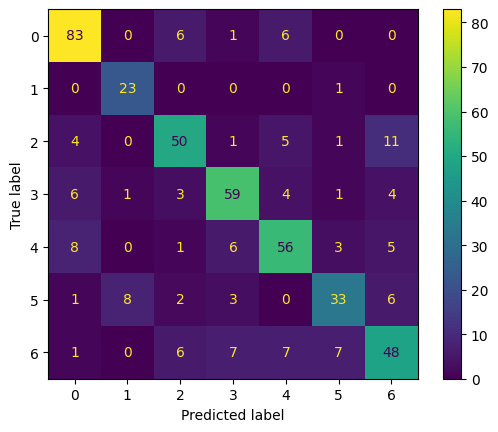


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']



In [13]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_rav = SVC().set_params(**svm_best_model.get_params())
svm_emo_rav.fit(X_train, y_train)
model_eval(svm_emo_rav, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
100.00% for the train data
69.29% for the test data

Evaluation: accuracy_score
100.00% for the train data
69.25% for the test data

Evaluation: precision_score
100.00% for the train data
68.82% for the test data

Evaluation: recall_score
100.00% for the train data
70.84% for the test data

Evaluation: confusion_matrix of test predictions


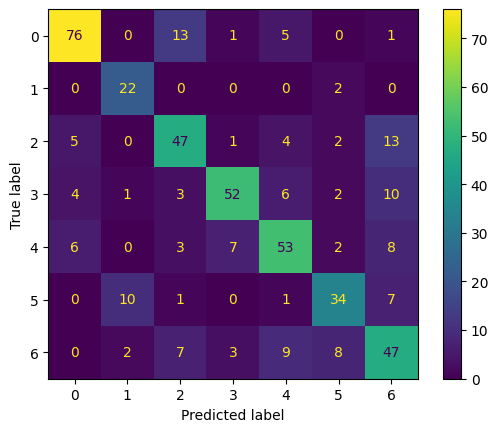


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']



In [14]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_rav = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_rav.fit(X_train, y_train)
model_eval(rfc_emo_rav, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
99.92% for the train data
68.49% for the test data

Evaluation: accuracy_score
99.91% for the train data
67.36% for the test data

Evaluation: precision_score
99.92% for the train data
68.41% for the test data

Evaluation: recall_score
99.92% for the train data
69.08% for the test data

Evaluation: confusion_matrix of test predictions


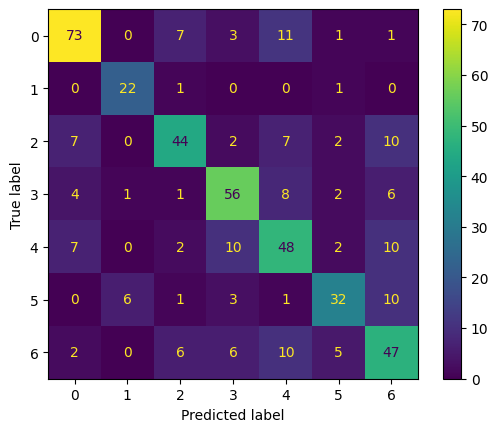


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']



In [15]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_rav = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_rav.fit(X_train, y_train)
model_eval(xgb_emo_rav, X_train, X_test, y_train, y_test, confusion=True)

## b) EmoDB + Ravdess own feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (1591, 578)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#############################################

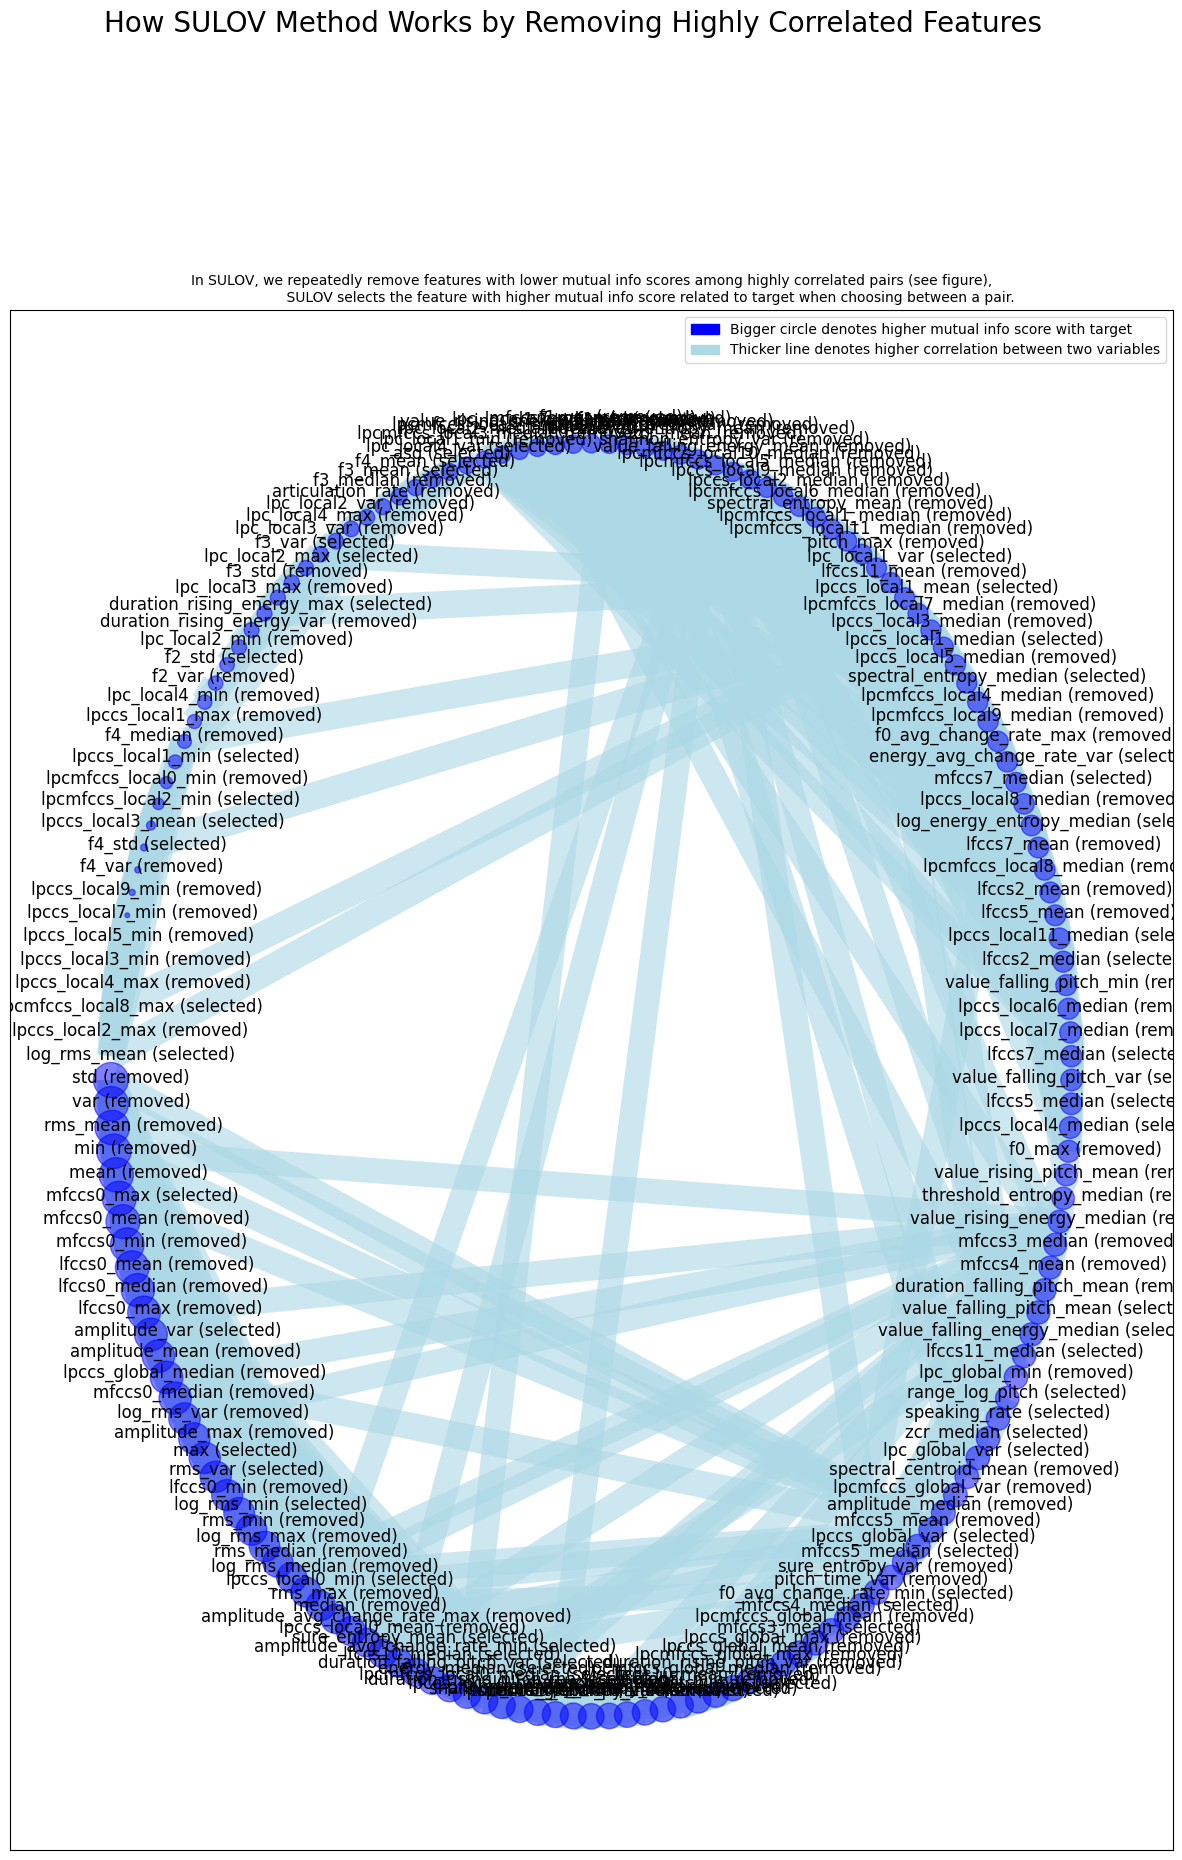

Time taken for SULOV method = 4 seconds
    Adding 0 categorical variables to reduced numeric variables  of 467
Finally 467 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 115 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 34 seconds
            Time taken for regular XGBoost feature selection = 28 seconds
            Time taken for regular XGBoost feature selection = 21 seconds
            Time taken for regular XGBoost feature selection = 14 seconds
            Time taken for regular XGBoost feature selection = 9 se

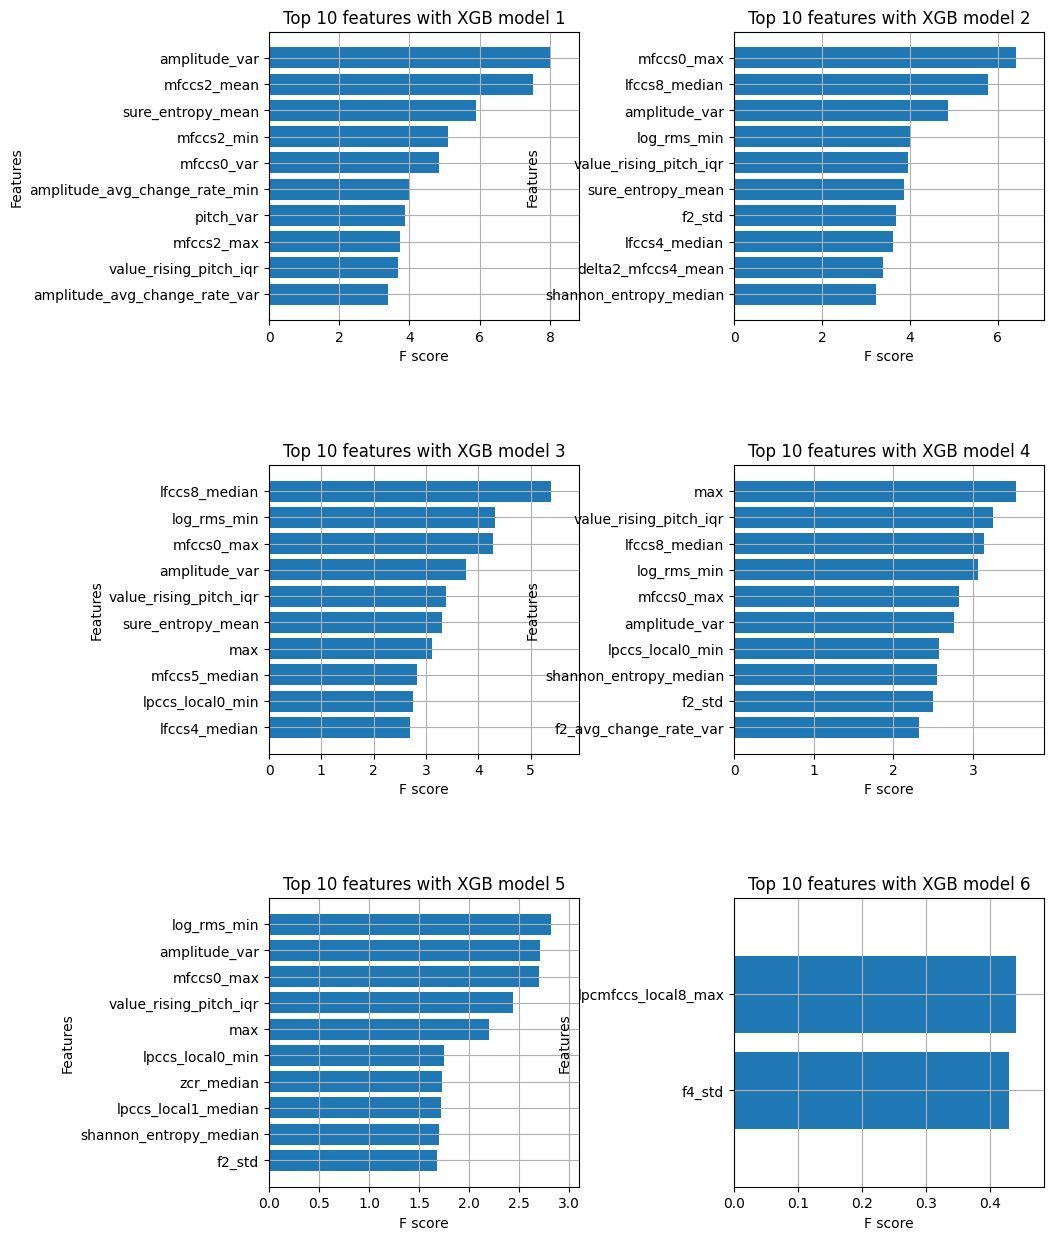

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 233 important features. Too many to print...
Total Time taken for featurewiz selection = 111 seconds
Output contains a list of 233 important features and a train dataframe


In [16]:
# automatic feature selection by using featurewiz package
selected_features_emo_rav, df_emo_rav_reduced = featurewiz(df_emo_rav, 'label', corr_limit=0.9, verbose=2, sep=",", 
                                                           header=0,test_data="", feature_engg="", category_encoders="")

In [17]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_rav_reduced, test_size=0.3)

A snippet of the data:


mfccs2_mean  mfccs0_var  mfccs2_min    f2_std       asd  \
929      0.460574    0.127237    0.226622  1.096726  0.733535   
332     -2.227416   -1.454022   -1.540456 -1.370479 -1.348642   
590     -0.774164    0.657194   -1.573120 -0.494105 -0.685591   
1057     0.275776    0.744431    0.584616 -1.217130  0.142471   
1272    -0.150976    0.822218    0.269429  0.730575 -0.615634   

      value_rising_pitch_iqr  amplitude_var  duration_rising_pitch_mean  \
929                -0.747259      -0.769282                    0.563947   
332                -0.148577       2.334459                   -1.145539   
590                 0.235534      -0.649280                    1.108520   
1057               -0.279007      -0.772419                    0.072621   
1272                0.478689      -0.172115                    0.860530   

      duration  mfccs2_max  lpc_local4_mean  amplitude_avg_change_rate_var  \
929   0.208182    0.079685        -0.842036                      -0.624576   
332  -1.268401   -0.516169        -1.002666                       2.923660   
590   0.586965    0.151822        -1.050943                      -0.609586   
1057  0.250281   -0.198078        -0.688801                      -0.624693   
1272  0.418623   -1.192069         1.844773                      -0.493883   

      lpc_global_mean  value_rising_pitch_median  lpccs_local1_median  \
929         -0.417337                  -0.612173             0.056217   
332          0.771973                  -0.041243            -0.970953   
590         -0.283999                   0.728220             0.249743   
1057        -0.527785                  -0.248950             0.813185   
1272        -0.561557                  -0.231009             0.307904   

      delta_mfccs5_min  lfccs4_var  mfccs0_max  speaking_rate  \
929           1.599976    1.480203   -1.259403      -0.889352   
332           1.171869    0.352045    1.139325       2.444835   
590          -1.015429   -0.542645   -0.142716      -0.371844   
1057          0.040016    0.579443   -0.943681      -0.679095   
1272          0.650669   -1.373745    0.432059      -0.519983   

      shannon_entropy_median  lfccs8_var  sure_entropy_mean  \
929                -0.284036   -0.066650          -0.947413   
332                 1.013334    1.119437           1.237716   
590                -0.285646   -0.341138          -0.865421   
1057               -0.773631   -1.025477          -0.866803   
1272                0.672565   -0.883646           0.045078   

      amplitude_avg_change_rate_min  f1_median  mfccs5_median   f1_mean  \
929                        0.774510  -0.167571       0.949235 -0.410147   
332                       -2.020860   1.492108      -3.624427  1.031825   
590                        0.575686   0.241334      -0.681281  0.541390   
1057                       0.839831   0.211899       0.105767 -0.274147   
1272                      -0.447690   0.994717       0.179455  0.979206   

           max  mfccs6_min  skew_log_pitch  lfccs3_max  mfccs2_var  \
929  -0.931482   -0.730656        0.393266    1.203639    0.124901   
332   1.437435    1.388362       -1.145640   -1.488391    1.529704   
590  -0.421704   -1.236757        0.484626    0.439607    0.991592   
1057 -0.960209   -0.523405        0.737583    0.517123   -0.817118   
1272  0.433106   -0.750149       -0.141208    0.705380   -0.647605   

      log_rms_min  f0_avg_change_rate_var  delta2_mfccs3_var  lfccs4_median  \
929     -0.376664               -0.607298          -0.653006       0.528616   
332     -0.199002                0.646477           1.204331      -1.677510   
590     -0.381306               -0.381077          -0.663922      -0.671668   
1057    -0.381306               -0.521512          -0.674762       0.832187   
1272    -0.375599               -0.032491          -0.761010      -0.480281   

      mfccs9_min   zcr_max  lfccs1_var  f1_avg_change_rate_var  mfccs1_median  \
929    -0.806159 -1.439237   -0.459344                0.31

There are 1113 entries with 233 columns in the training data.
There are 478 entries with 233 columns in the testing data.


### SVM


Evaluation: f1_score
100.00% for the train data
80.18% for the test data

Evaluation: accuracy_score
100.00% for the train data
80.96% for the test data

Evaluation: precision_score
100.00% for the train data
80.14% for the test data

Evaluation: recall_score
100.00% for the train data
80.61% for the test data

Evaluation: confusion_matrix of test predictions


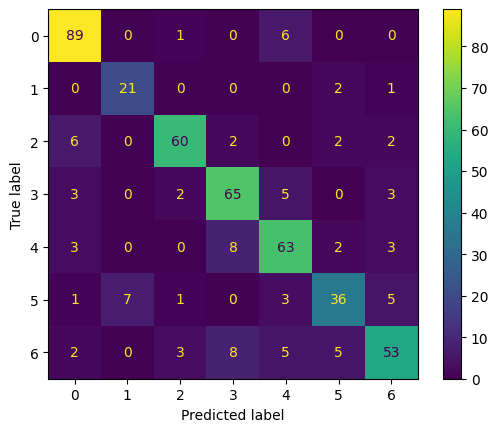


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']



In [18]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_rav_reduced = SVC().set_params(**svm_best_model.get_params())
svm_emo_rav_reduced.fit(X_train, y_train)
model_eval(svm_emo_rav_reduced, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
100.00% for the train data
73.58% for the test data

Evaluation: accuracy_score
100.00% for the train data
73.43% for the test data

Evaluation: precision_score
100.00% for the train data
72.85% for the test data

Evaluation: recall_score
100.00% for the train data
75.34% for the test data

Evaluation: confusion_matrix of test predictions


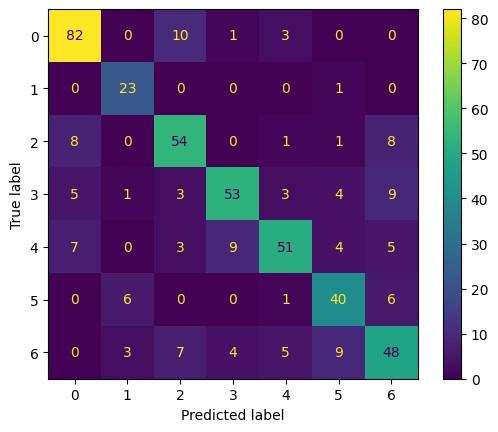


Hard cases for the model:



In [19]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_rav_reduced = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_rav_reduced.fit(X_train, y_train)
model_eval(rfc_emo_rav_reduced, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
100.00% for the train data
75.29% for the test data

Evaluation: accuracy_score
100.00% for the train data
74.90% for the test data

Evaluation: precision_score
100.00% for the train data
74.88% for the test data

Evaluation: recall_score
100.00% for the train data
76.11% for the test data

Evaluation: confusion_matrix of test predictions


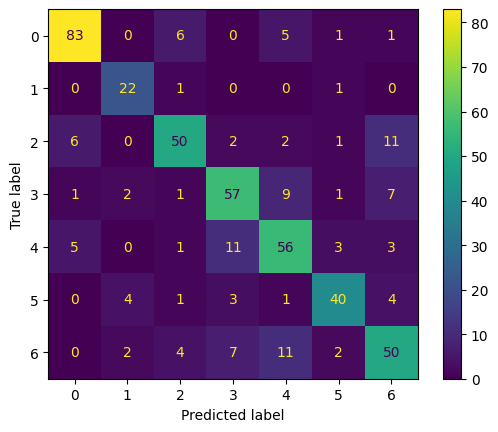


Hard cases for the model:



In [20]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_rav_reduced = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_rav_reduced.fit(X_train, y_train)
model_eval(xgb_emo_rav_reduced, X_train, X_test, y_train, y_test, confusion=True)

# 3) IEMOCAP only
## a) Iemocap with most important features from featurewiz 97

In [21]:
# get most important features (featurewiz 97)
df = pd.read_pickle('../results/df_prep_most_important97.pkl')
feat_most_imp97 = df.columns.to_list()

# load data
df_iemocap = pd.read_pickle('../results/df_prep_numerical_only_all_stats_iemocap.pkl')

# check if there are any features in the saved set of most important features from emodb
mis_cols = list(set(feat_most_imp97) - set(df_iemocap.columns.to_list()))
print(f'{mis_cols} are missing in the Iemocap feature set and are removed from the list.')
for feat in mis_cols:
    feat_most_imp97.remove(feat) 

# select features
df_iemocap_most_imp97 = df_iemocap[feat_most_imp97]

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_iemocap_most_imp97, test_size=0.3)

[] are missing in the Iemocap feature set and are removed from the list.
A snippet of the data:


rms_min  mfccs5_mean   zcr_max  duration_rising_pitch_max  \
735  -0.229509    -1.070334  0.729021                  -0.918953   
1247 -0.377306     1.719883 -1.351664                  -0.311118   
1362 -0.389425     0.639489 -0.523430                   0.209883   
1759 -0.298078     1.463116  0.772789                   1.668688   
759  -0.273248    -0.196919 -0.991416                  -1.092620   

      lpccs_local4_min  lfccs9_max       min  energy_median  lfccs0_median  \
735          -0.156343   -0.093146 -3.084508       0.107065       2.826949   
1247          1.141032   -0.184050  0.834509      -0.116537      -1.425913   
1362          0.082592    0.566703  0.679285      -0.369601      -0.719986   
1759          0.070874    0.218921  0.702696      -0.637881      -1.078084   
759          -0.334691   -1.201885  0.626730       2.173135      -0.115169   

      lpccs_global_median  lpc_global_mean  value_falling_energy_max  \
735              2.520223         4.719214                  0.170306   
1247            -1.732743        -0.992621                  0.112599   
1362            -0.798659        -0.355743                  0.142788   
1759             0.387390         1.493283                  0.164857   
759             -0.695362        -0.720937                 -0.848937   

      mfccs11_mean    f1_min  lpc_local3_var  lpccs_local0_var  \
735       0.894106  1.194629       -0.533807          0.751138   
1247      0.582794  0.377720       -0.738245         -1.295066   
1362      0.774411  0.620137       -0.082941         -0.133597   
1759      1.665823 -0.063391       -0.494647          0.211192   
759       0.202500  0.895814        0.739660         -1.004836   

      f0_avg_change_rate_median  lfccs9_median  delta_mfccs0_min  \
735                    0.044621      -2.198986         -2.274826   
1247                   0.044621      -0.432425          0.332266   
1362                   0.044621       0.069071          0.336453   
1759                   0.044621       0.830515         -0.308741   
759                    0.044621      -0.497633          1.201858   

      value_falling_pitch_iqr  lpc_local1_mean  f1_avg_change_rate_var  \
735                  0.413975         0.984686               -0.733091   
1247                -0.681845        -0.726682                0.954749   
1362                 1.133583        -0.836912               -0.842719   
1759                -0.394398         1.396344                8.455950   
759                 -0.476155        -1.277714               -0.656736   

      threshold_entropy_var  mfccs3_max   f2_mean  lfccs7_var  lfccs9_var  \
735               -0.416816    0.434847  1.713011    1.035709    0.975585   
1247              -1.790686    0.776187 -1.199529   -1.227328   -0.948690   
1362              -0.214514    0.196125  0.861754    0.773685    0.014319   
1759               0.127121    0.528973  0.780741   -0.441897   -0.832678   
759               -1.301905   -1.218798 -1.189658    0.307843   -0.618574   

      delta_mfccs5_median  mfccs4_max  energy_var  delta2_mfccs3_min  \
735              0.172940    0.079476   -0.598227          -0.202604   
1247             0.006834    0.383063    1.101588          -1.182161   
1362            -0.818626   -0.148326    0.384843           0.513254   
1759            -0.023920    0.952114   -0.514664           0.844515   
759             -0.056390   -1.448587   -0.122595           0.623839   

      lpccs_local5_mean  shannon_entropy_mean  delta2_mfccs5_mean  \
735            0.378881              1.207572           -0.087208   
1247           0.624628             -0.488350           -0.095337   
1362          -0.032855             -0.713716           -0.745356   
1759           1.172223             -0.289582            0.171262   
759           -0.738778              1.310796           -0.171188   

      delta_mfccs4_median   f3_mean  mfccs5_var  voiced_var  \
735              0.728528  0.940906    0.968759    0.879998   
1247    

There are 1565 entries with 97 columns in the training data.
There are 672 entries with 97 columns in the testing data.


### SVM


Evaluation: f1_score
99.60% for the train data
44.88% for the test data

Evaluation: accuracy_score
99.49% for the train data
62.35% for the test data

Evaluation: precision_score
99.53% for the train data
45.03% for the test data

Evaluation: recall_score
99.68% for the train data
45.26% for the test data

Evaluation: confusion_matrix of test predictions


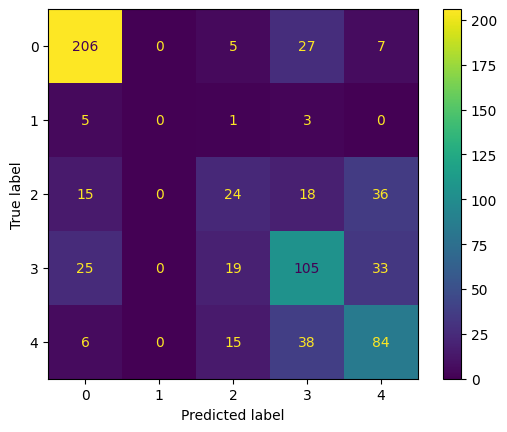


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'neutral(3)']

Label: happiness(2)
Hard cases of false negatives: ['sadness(4)']
Hard cases of false positives: ['neutral(3)', 'sadness(4)']

Label: sadness(4)
Hard cases of false negatives: ['neutral(3)']
Hard cases of false positives: ['happiness(2)', 'neutral(3)']



In [22]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_iemocap = SVC().set_params(**svm_best_model.get_params())
svm_iemocap.fit(X_train, y_train)
model_eval(svm_iemocap, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

### Random Forest


Evaluation: f1_score
99.17% for the train data
43.15% for the test data

Evaluation: accuracy_score
98.85% for the train data
61.90% for the test data

Evaluation: precision_score
99.01% for the train data
44.90% for the test data

Evaluation: recall_score
99.36% for the train data
44.09% for the test data

Evaluation: confusion_matrix of test predictions


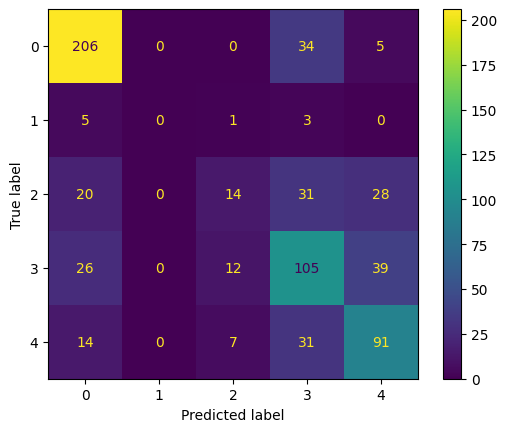


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'neutral(3)']

Label: happiness(2)
Hard cases of false negatives: ['anger(0)', 'neutral(3)', 'sadness(4)']
Hard cases of false positives: ['neutral(3)', 'sadness(4)']

Label: neutral(3)
Hard cases of false negatives: ['sadness(4)']

Label: sadness(4)
Hard cases of false negatives: ['neutral(3)']
Hard cases of false positives: ['neutral(3)']



In [23]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_iemocap = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_iemocap.fit(X_train, y_train)
model_eval(rfc_iemocap, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

### XGB


Evaluation: f1_score
94.85% for the train data
44.44% for the test data

Evaluation: accuracy_score
94.12% for the train data
62.50% for the test data

Evaluation: precision_score
95.61% for the train data
45.64% for the test data

Evaluation: recall_score
94.29% for the train data
44.90% for the test data

Evaluation: confusion_matrix of test predictions


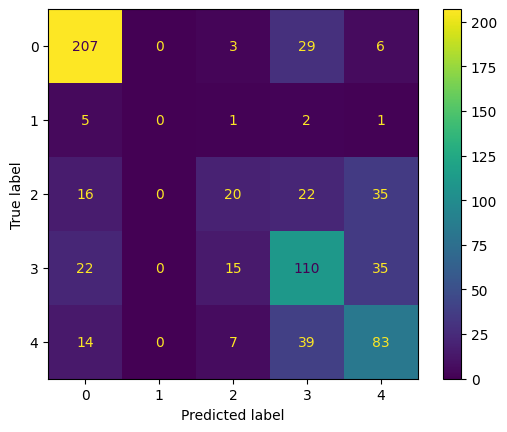


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'neutral(3)']

Label: happiness(2)
Hard cases of false negatives: ['neutral(3)', 'sadness(4)']
Hard cases of false positives: ['neutral(3)']

Label: sadness(4)
Hard cases of false negatives: ['neutral(3)']
Hard cases of false positives: ['happiness(2)', 'neutral(3)']



In [24]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_iemocap = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_iemocap.fit(X_train, y_train)
model_eval(xgb_iemocap, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

## b) IEMOCAP own feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (2237, 595)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#############################################

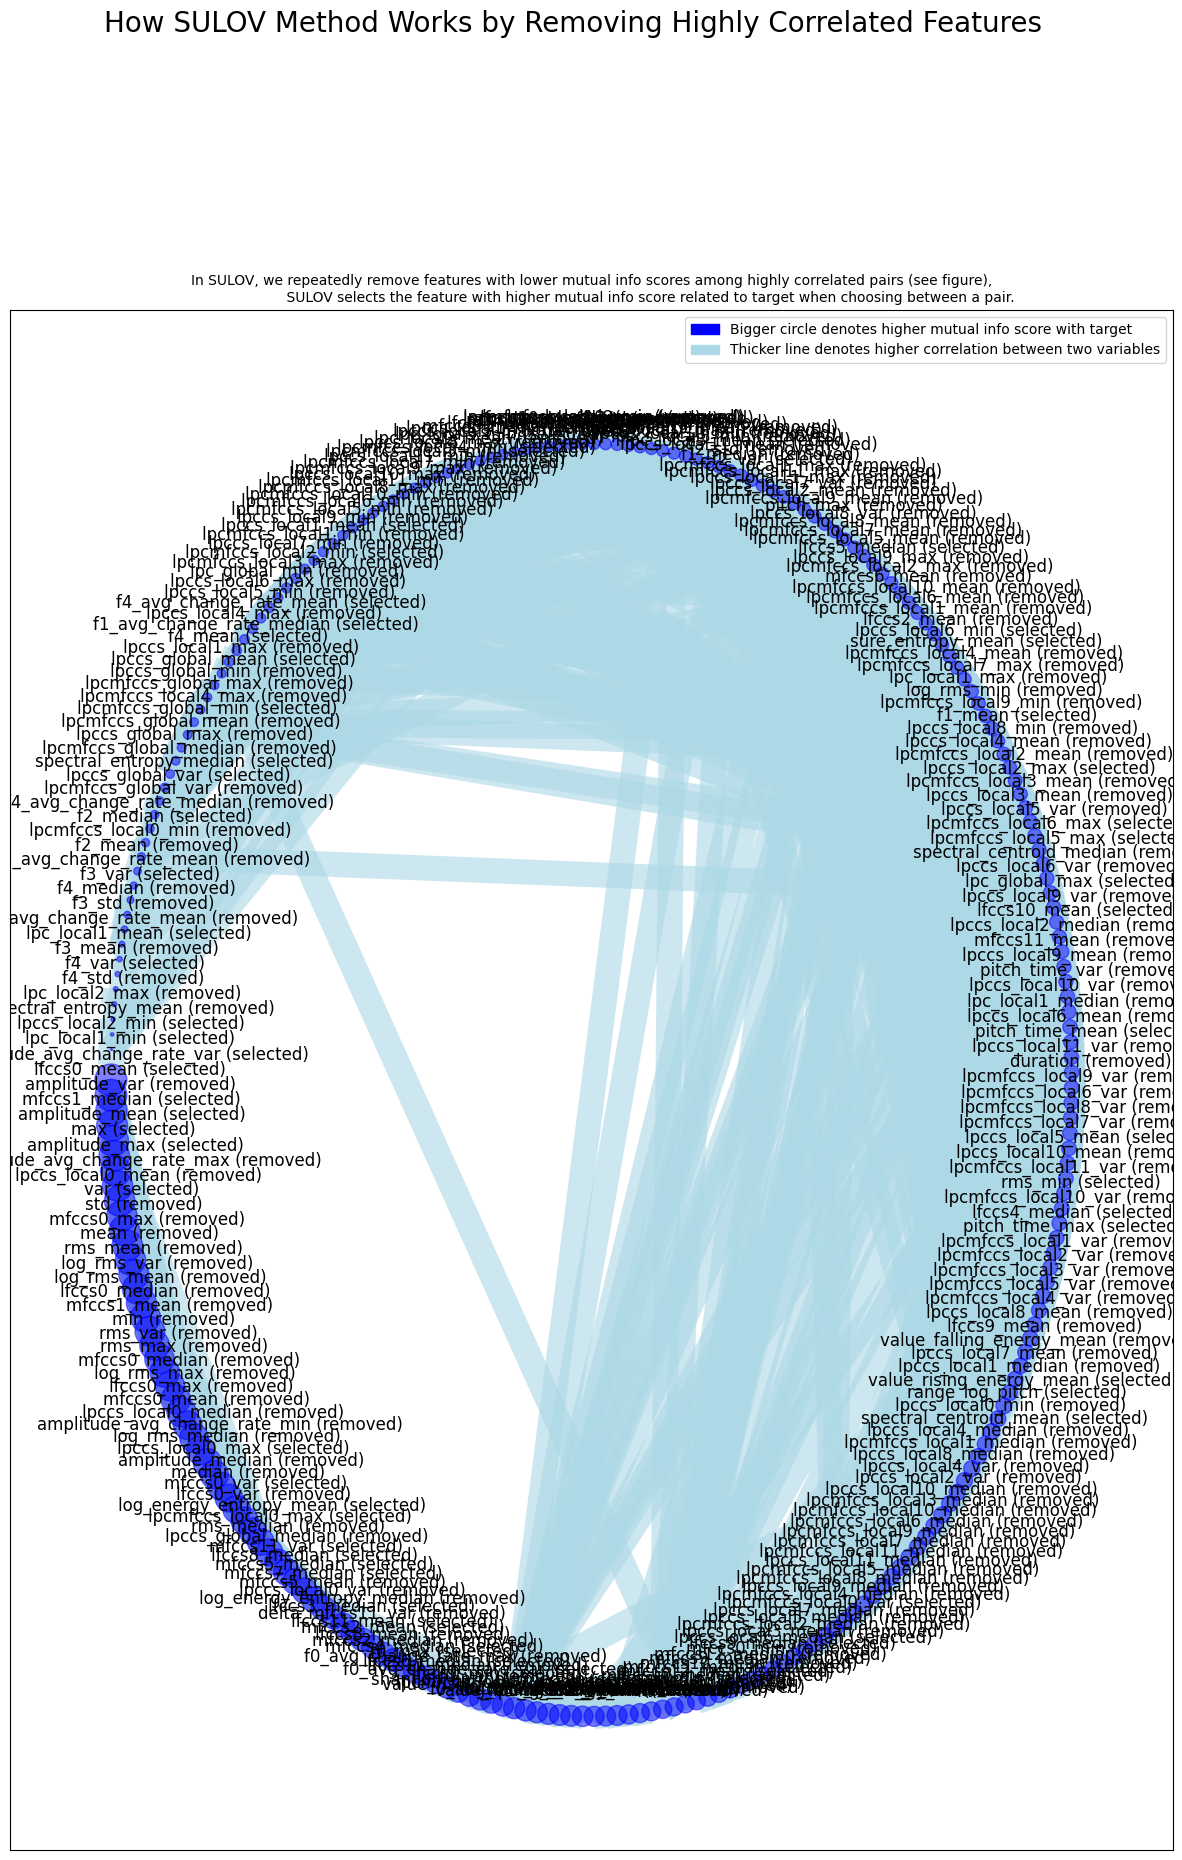

Time taken for SULOV method = 6 seconds
    Adding 0 categorical variables to reduced numeric variables  of 409
Finally 409 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 118 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 45 seconds
            Time taken for regular XGBoost feature selection = 37 seconds
            Time taken for regular XGBoost feature selection = 29 seconds
            Time taken for regular XGBoost feature selection = 20 seconds
            Time taken for regular XGBoost feature selection = 11 s

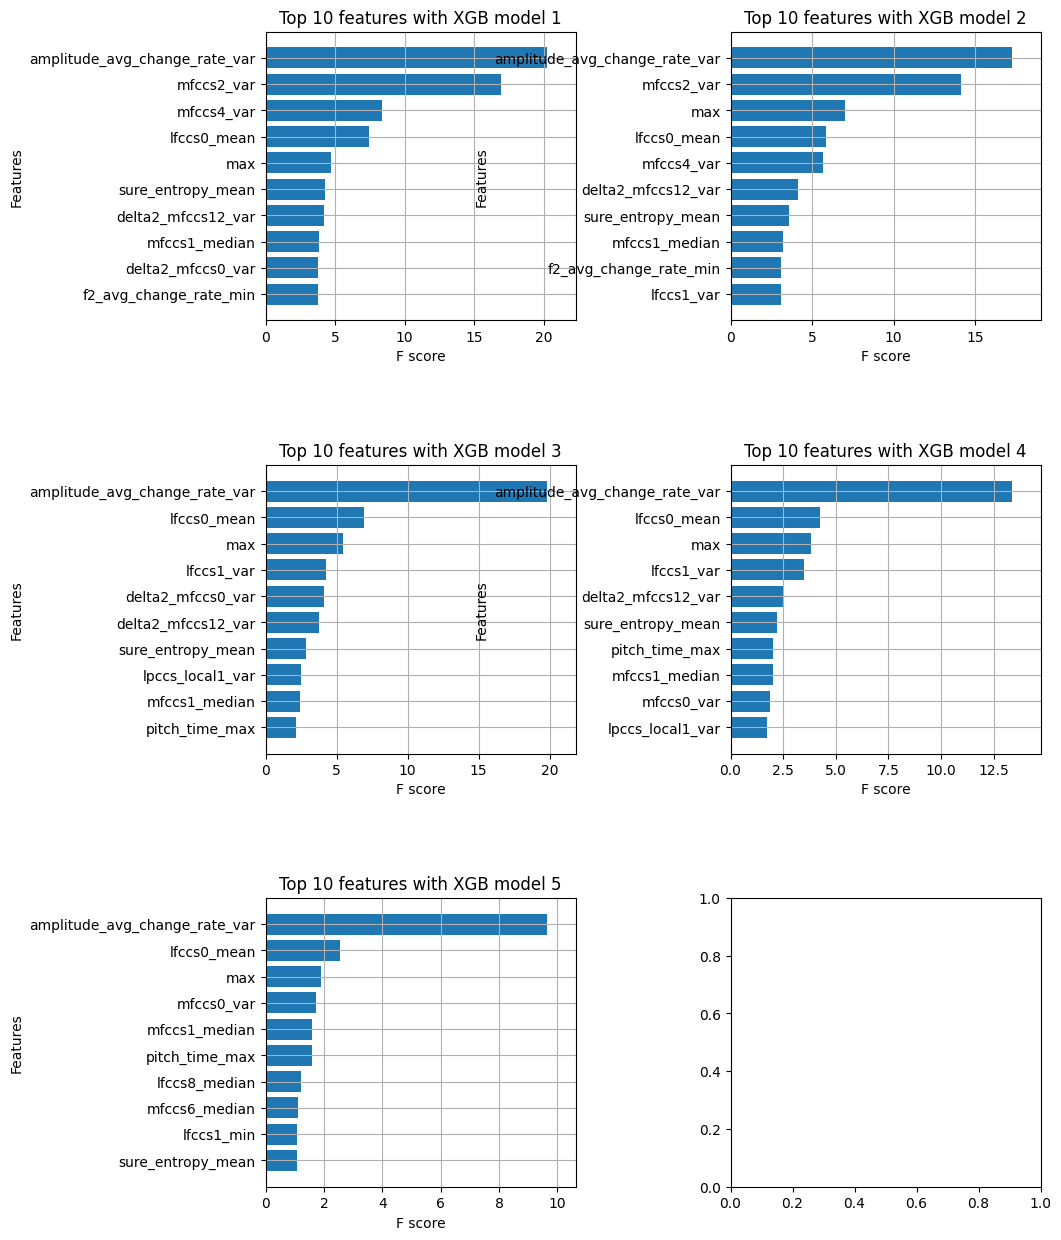

    Completed XGBoost feature selection in 11 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 236 important features. Too many to print...
Total Time taken for featurewiz selection = 149 seconds
Output contains a list of 236 important features and a train dataframe


In [25]:
# automatic feature selection by using featurewiz package
selected_features_iemocap, df_iemocap_reduced = featurewiz(df_iemocap, 'label', corr_limit=0.9, verbose=2, sep=",", 
                                                           header=0,test_data="", feature_engg="", category_encoders="")

In [26]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_iemocap_reduced, test_size=0.3)

A snippet of the data:


amplitude_avg_change_rate_var  mfccs2_var  lfccs0_mean  \
735                        4.782250    0.243090     3.055224   
1247                      -0.398839   -1.087686    -1.402438   
1362                      -0.378280    0.039262    -0.861460   
1759                      -0.390136   -0.791433    -0.709181   
759                       -0.387307   -0.304133    -0.216559   

      pitch_time_median  mfccs4_var  mfccs1_median  delta2_mfccs0_var  \
735            1.904481    1.739941      -3.499218           1.982402   
1247          -0.064386   -0.941878       1.349354          -0.764567   
1362          -0.709280   -0.501956       1.090232          -0.029583   
1759           0.628681   -0.617049       1.085007          -0.843354   
759           -0.409110   -0.718658       0.809602          -0.748500   

           max  mfccs1_max  sure_entropy_mean  delta2_mfccs3_var  \
735   3.031496   -2.181321           1.252378           0.412316   
1247 -0.814788    0.370782           0.627514           0.168712   
1362 -0.588924   -0.228461          -0.857425          -0.244585   
1759 -0.641300    0.908905           0.788265          -1.096503   
759  -0.713943    0.602307          -0.124207           0.328712   

      delta2_mfccs12_var  lfccs1_var  f2_avg_change_rate_min  \
735             1.617647   -0.320022               -0.056758   
1247           -0.923097   -1.210387               -0.601134   
1362            0.277600   -0.387259                1.888006   
1759           -0.718660   -0.584673               -0.176987   
759            -0.355655   -0.240203               -0.586511   

      delta_mfccs0_var  mfccs0_var  lfccs8_min  mfccs6_median  \
735           1.346256    1.355968   -1.705755      -1.084966   
1247         -1.029794   -1.044708    0.920174       0.886783   
1362          0.459728    0.022134    1.333117       0.381976   
1759         -0.491817    0.307438   -0.439415       0.518742   
759          -0.707723   -1.119552    0.303497      -0.493764   

      lpc_global_mean  mfccs2_max  mfccs9_mean  pitch_var  \
735          4.719214   -0.040104    -0.624919   2.850535   
1247        -0.992621   -1.370020     0.959718  -1.122557   
1362        -0.355743    0.049488    -0.646605   0.497048   
1759         1.493283   -0.929755     0.932348  -0.904909   
759         -0.720937    0.498346     0.418498  -0.031896   

      duration_rising_pitch_max  mfccs6_var  mfccs8_mean  lfccs4_var  \
735                   -0.918953    0.375592    -1.660413    0.648246   
1247                  -0.311118   -0.884192    -0.228552   -1.419259   
1362                   0.209883   -0.118806     0.383907   -0.900484   
1759                   1.668688   -0.857556    -0.245102    0.607382   
759                   -1.092620   -0.635888    -0.458729   -0.074517   

      spectral_entropy_var  lpc_local3_var  delta2_mfccs0_min  \
735               0.441523       -0.533807          -1.157142   
1247             -1.033168       -0.738245           0.713694   
1362             -0.681080       -0.082941          -0.699176   
1759              0.642339       -0.494647           0.634974   
759               0.067640        0.739660           1.278681   

      delta_mfccs3_median  energy_avg_change_rate_var  lfccs7_var    f1_var  \
735              0.074963                   -0.316084    1.035709  0.328682   
1247            -0.032566                    0.700115   -1.227328 -0.383899   
1362             0.378760                   -0.471861    0.773685 -1.248276   
1759             0.205697                   -0.681834   -0.441897  6.137433   
759             -0.143107                    0.342317    0.307843 -0.744147   

      delta_mfccs0_max  f4_avg_change_rate_var  mfccs12_mean  mfccs11_median  \
735           1.050777               -0.797673     -0.219328        0.396796   
1247         -1.335875                0.192488     -0.387268        0.722424   
1362          1.001303               -0.596364     -0.360139        0.101395   
1759       

There are 1565 entries with 236 columns in the training data.
There are 672 entries with 236 columns in the testing data.


### SVM


Evaluation: f1_score
99.81% for the train data
52.23% for the test data

Evaluation: accuracy_score
99.74% for the train data
65.48% for the test data

Evaluation: precision_score
99.79% for the train data
68.26% for the test data

Evaluation: recall_score
99.84% for the train data
50.60% for the test data

Evaluation: confusion_matrix of test predictions


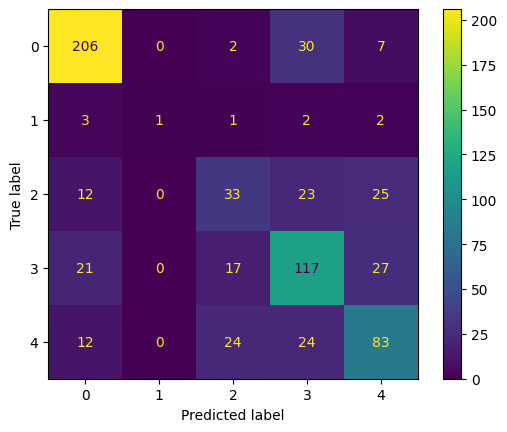


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'neutral(3)', 'sadness(4)']

Label: happiness(2)
Hard cases of false negatives: ['neutral(3)', 'sadness(4)']
Hard cases of false positives: ['neutral(3)', 'sadness(4)']



In [27]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_iemocap_reduced = SVC().set_params(**svm_best_model.get_params())
svm_iemocap_reduced.fit(X_train, y_train)
model_eval(svm_iemocap_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

### Random Forest


Evaluation: f1_score
99.20% for the train data
46.51% for the test data

Evaluation: accuracy_score
98.85% for the train data
65.18% for the test data

Evaluation: precision_score
99.06% for the train data
49.01% for the test data

Evaluation: recall_score
99.36% for the train data
47.16% for the test data

Evaluation: confusion_matrix of test predictions


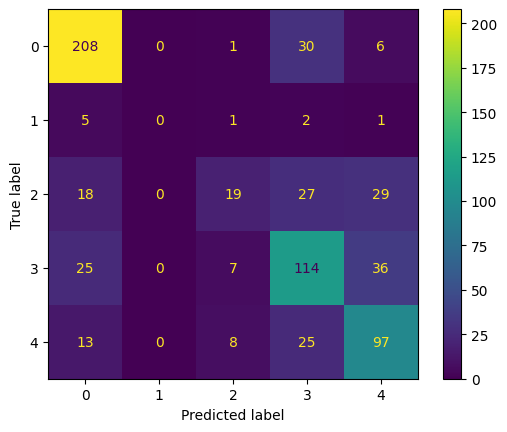


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'neutral(3)']

Label: happiness(2)
Hard cases of false negatives: ['neutral(3)', 'sadness(4)']
Hard cases of false positives: ['sadness(4)']

Label: sadness(4)
Hard cases of false positives: ['neutral(3)']



In [28]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_iemocap_reduced = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_iemocap_reduced.fit(X_train, y_train)
model_eval(rfc_iemocap_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

### XGB


Evaluation: f1_score
96.79% for the train data
47.16% for the test data

Evaluation: accuracy_score
96.36% for the train data
65.03% for the test data

Evaluation: precision_score
97.01% for the train data
47.86% for the test data

Evaluation: recall_score
96.58% for the train data
47.40% for the test data

Evaluation: confusion_matrix of test predictions


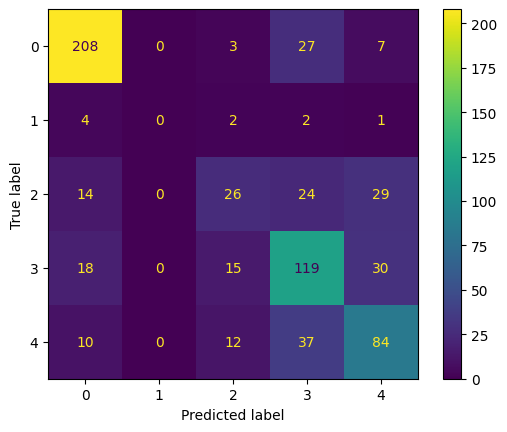


Hard cases for the model:

Label: fear(1)
Hard cases of false negatives: ['anger(0)', 'happiness(2)', 'neutral(3)']

Label: happiness(2)
Hard cases of false negatives: ['neutral(3)', 'sadness(4)']
Hard cases of false positives: ['neutral(3)', 'sadness(4)']

Label: sadness(4)
Hard cases of false negatives: ['neutral(3)']



In [29]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_iemocap_reduced = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_iemocap_reduced.fit(X_train, y_train)
model_eval(xgb_iemocap_reduced, X_train, X_test, y_train, y_test, confusion=True, emotions='iemocap')

# 4) EmoDB + IEMOCAP
## a) EmoDB + Iemocap with most important features from featurewiz 97

In [30]:
# get most important features (featurewiz 97)
df = pd.read_pickle('../results/df_prep_most_important97.pkl')
feat_most_imp97 = df.columns.to_list() 

# load data
df_emo_iemo = pd.read_pickle('../results/df_prep_numerical_only_all_stats_emodb_iemocap.pkl')

# check if there are any features in the saved set of most important features from emodb
mis_cols = list(set(feat_most_imp97) - set(df_emo_iemo.columns.to_list()))
print(f'{mis_cols} are missing in the Iemocap feature set and are removed from the list.')
for feat in mis_cols:
    feat_most_imp97.remove(feat)
    
# select features    
df_emo_iemo_most_imp97 = df_emo_iemo[feat_most_imp97]

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_iemo_most_imp97, test_size=0.3)

[] are missing in the Iemocap feature set and are removed from the list.
A snippet of the data:


rms_min  mfccs5_mean   zcr_max  duration_rising_pitch_max  \
128  -0.746492    -1.711497  0.935236                  -0.911828   
1972 -0.209122    -1.098953 -1.584993                  -0.130259   
2678 -0.468242     0.366442  0.424769                   2.960491   
1337 -0.199037     0.694832 -1.495100                  -0.219074   
2625 -0.471788     0.611317  0.463295                  -0.751962   

      lpccs_local4_min  lfccs9_max       min  energy_median  lfccs0_median  \
128          -0.840101   -0.021783 -1.036905       0.167510       1.583046   
1972          1.282675   -1.187382  0.437044      -0.846816      -1.023071   
2678         -0.491134    0.112092  0.799012      -0.732693      -1.092563   
1337          1.207263    0.449135  0.684464      -0.538751      -0.520697   
2625         -0.569476   -0.745534  0.782136       0.610738      -0.443773   

      lpccs_global_median  lpc_global_mean  value_falling_energy_max  \
128              1.622048         4.467967                  0.005330   
1972            -0.305225        -0.799335                  0.240868   
2678            -0.262102        -0.474557                  0.242156   
1337            -0.709019        -0.849474                  0.233272   
2625            -0.499812        -0.176325                  0.237809   

      mfccs11_mean    f1_min  lpc_local3_var  lpccs_local0_var  \
128      -1.906567  0.963039       -0.098615          2.263613   
1972     -0.156345  1.053057       -0.992643          1.716610   
2678      0.078891 -1.417199       -0.239027         -0.504246   
1337      1.333995 -1.168519        0.080997          0.678727   
2625      0.344249  0.607119        0.078019         -0.583236   

      f0_avg_change_rate_median  lfccs9_median  delta_mfccs0_min  \
128                    0.165083       0.293588         -4.777903   
1972                   0.165083       0.551846         -0.088428   
2678                   0.165083       0.032778          0.851841   
1337                   0.165083       0.424242         -0.164528   
2625                   0.165083       0.048677          0.752092   

      value_falling_pitch_iqr  lpc_local1_mean  f1_avg_change_rate_var  \
128                  1.595951         1.141551               -0.730958   
1972                 0.728749        -0.708353               -0.603301   
2678                -0.543322        -0.284307               -0.301032   
1337                -0.253601        -0.439440               -0.193625   
2625                -0.260052         0.353866               -0.595980   

      threshold_entropy_var  mfccs3_max   f2_mean  lfccs7_var  lfccs9_var  \
128               -1.332548   -0.864545  0.942404    2.147966   -0.142802   
1972               2.144481    0.416009  2.349877   -0.599219   -0.770650   
2678               0.977739    0.730973  0.922826   -0.857281   -1.076348   
1337               1.517898    1.899979  0.378901    0.300513   -0.623158   
2625               0.573758   -0.923092  0.013143    0.035408   -0.358950   

      delta_mfccs5_median  mfccs4_max  energy_var  delta2_mfccs3_min  \
128              0.817522    0.042652   -0.123832          -0.323829   
1972             0.474352   -0.678304    1.371180          -1.220559   
2678             0.133942   -0.176358   -2.074778          -0.249409   
1337            -1.625903    0.310148    0.951262          -2.279272   
2625            -0.741729   -0.622101    1.549183           0.199057   

      lpccs_local5_mean  shannon_entropy_mean  delta2_mfccs5_mean  \
128            1.241725              0.303131            2.296486   
1972          -0.070623             -1.238541           -0.377945   
2678          -0.207200             -1.320228            0.077119   
1337           0.052812             -0.030005            0.017080   
2625          -0.506730             -0.017447            0.083606   

      delta_mfccs4_median   f3_mean  mfccs5_var  voiced_var  \
128              5.123838  1.893730   -0.217729    0.360984   
1972    

There are 1941 entries with 97 columns in the training data.
There are 832 entries with 97 columns in the testing data.


### SVM


Evaluation: f1_score
98.58% for the train data
62.68% for the test data

Evaluation: accuracy_score
97.84% for the train data
64.90% for the test data

Evaluation: precision_score
98.41% for the train data
65.76% for the test data

Evaluation: recall_score
98.78% for the train data
60.91% for the test data

Evaluation: confusion_matrix of test predictions


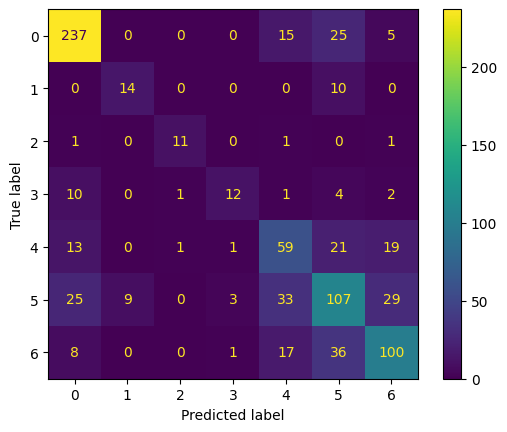


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false positives: ['neutral(5)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [31]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_iemo = SVC().set_params(**svm_best_model.get_params())
svm_emo_iemo.fit(X_train, y_train)
model_eval(svm_emo_iemo, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
98.36% for the train data
58.54% for the test data

Evaluation: accuracy_score
97.22% for the train data
64.90% for the test data

Evaluation: precision_score
98.07% for the train data
60.34% for the test data

Evaluation: recall_score
98.69% for the train data
61.82% for the test data

Evaluation: confusion_matrix of test predictions


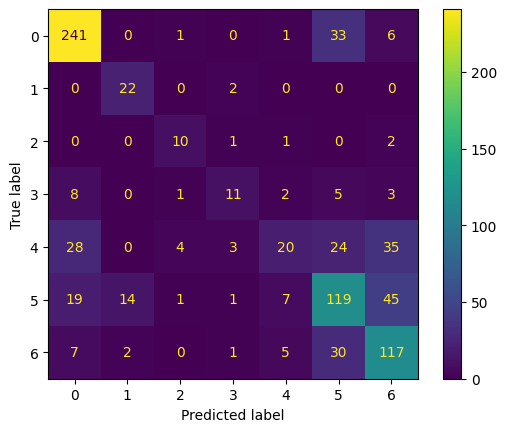


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false positives: ['happiness(4)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'neutral(5)', 'sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['sadness(6)']

Label: sadness(6)
Hard cases of false positives: ['neutral(5)']



In [32]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_iemo = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_iemo.fit(X_train, y_train)
model_eval(rfc_emo_iemo, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
94.95% for the train data
59.42% for the test data

Evaluation: accuracy_score
92.58% for the train data
65.02% for the test data

Evaluation: precision_score
95.61% for the train data
66.56% for the test data

Evaluation: recall_score
94.51% for the train data
55.89% for the test data

Evaluation: confusion_matrix of test predictions


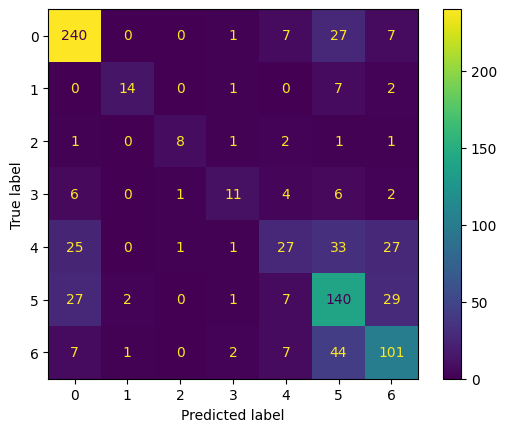


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'neutral(5)', 'sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [33]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_iemo = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_iemo.fit(X_train, y_train)
model_eval(xgb_emo_iemo, X_train, X_test, y_train, y_test, confusion=True)

# b) EmoDB + Iemocap own feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (2773, 594)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#############################################

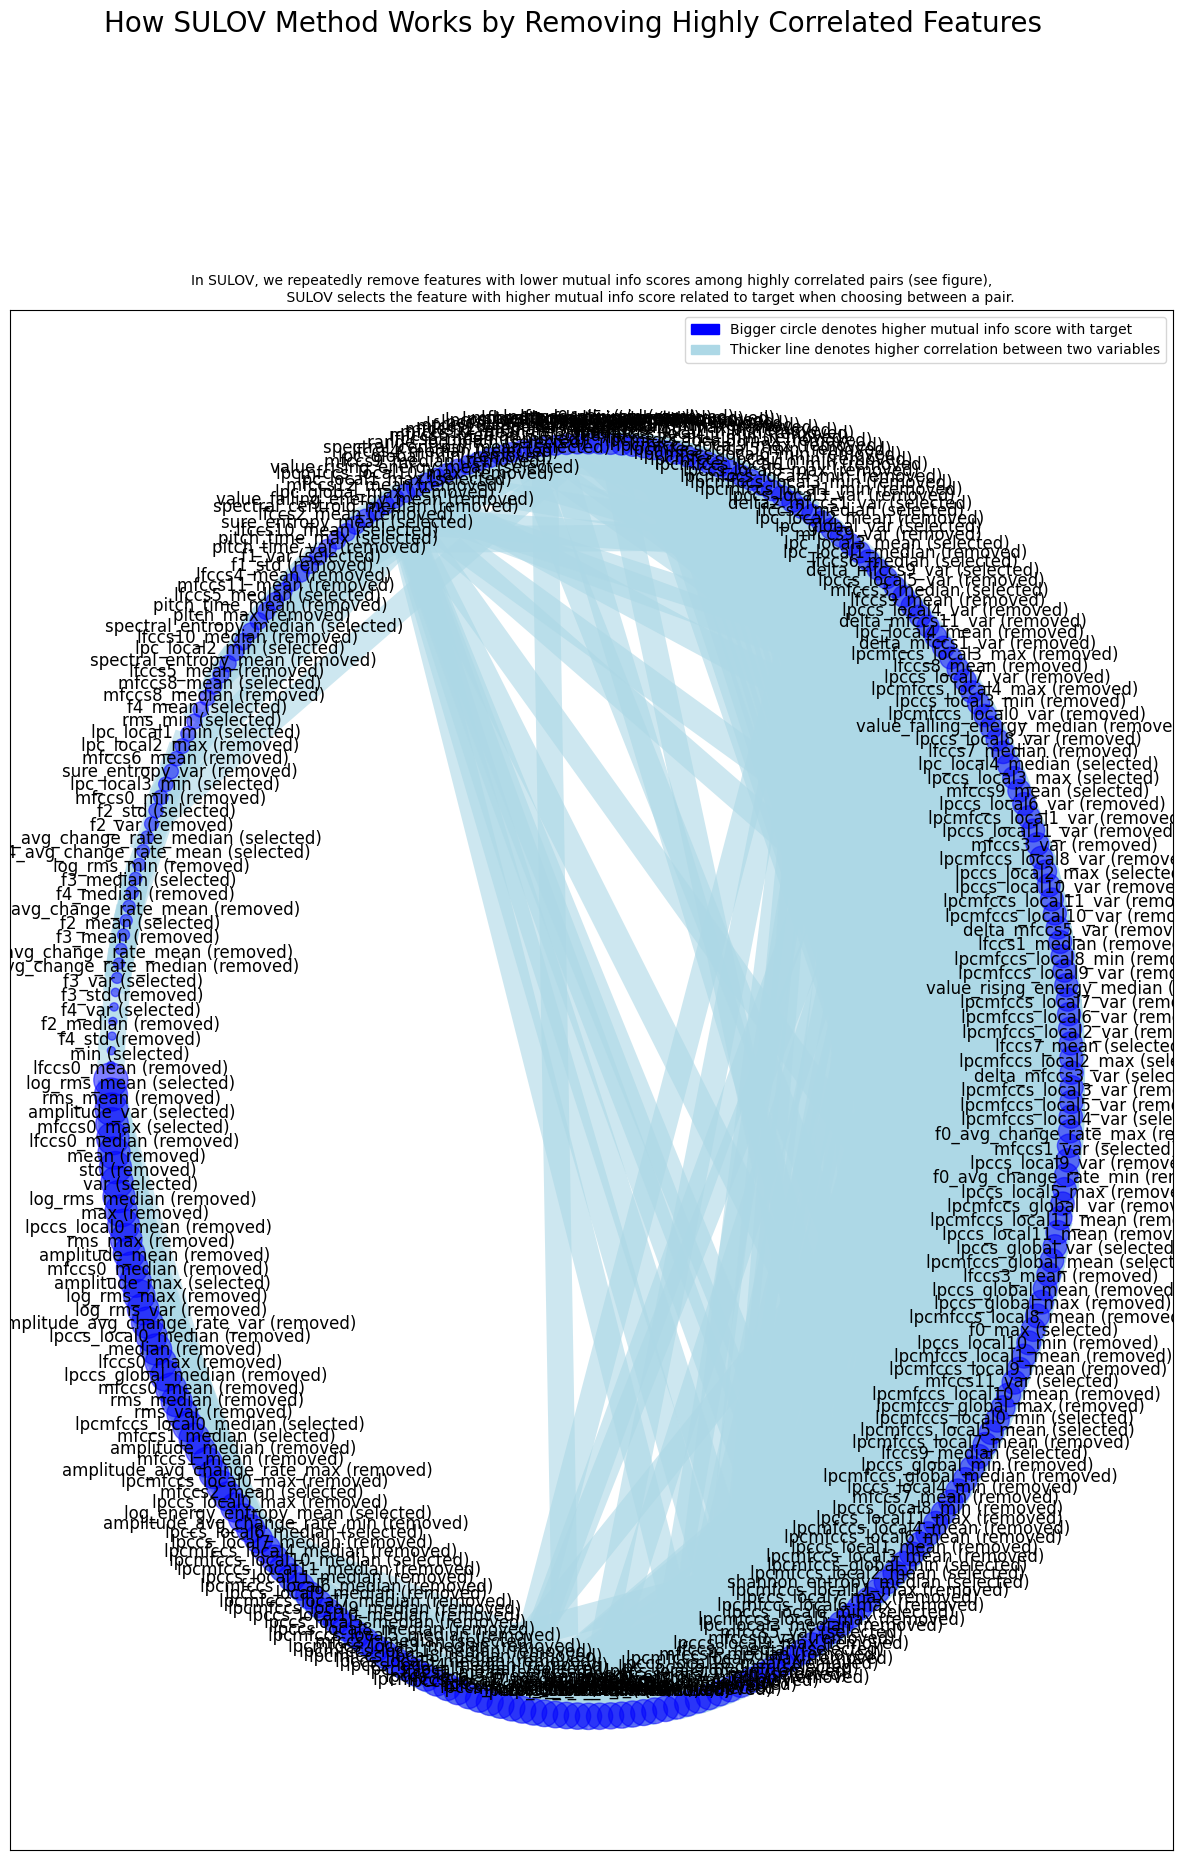

Time taken for SULOV method = 8 seconds
    Adding 0 categorical variables to reduced numeric variables  of 405
Finally 405 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 118 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 67 seconds
            Time taken for regular XGBoost feature selection = 56 seconds
            Time taken for regular XGBoost feature selection = 44 seconds
            Time taken for regular XGBoost feature selection = 29 seconds
            Time taken for regular XGBoost feature selection = 16 s

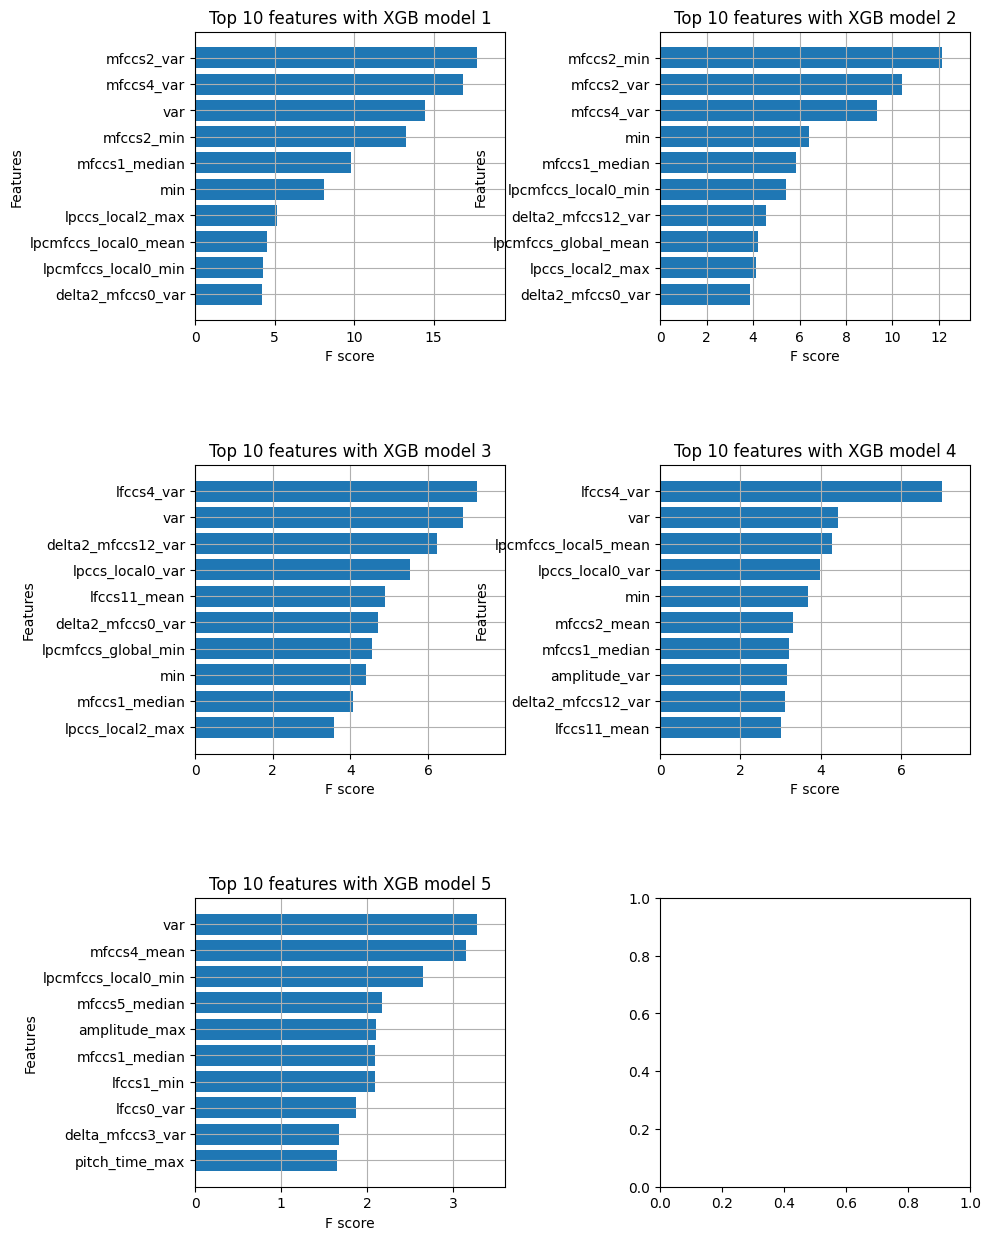

    Completed XGBoost feature selection in 17 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 229 important features. Too many to print...
Total Time taken for featurewiz selection = 221 seconds
Output contains a list of 229 important features and a train dataframe


In [34]:
# automatic feature selection by using featurewiz package
selected_features_emo_iemo, df_emo_iemo_reduced = featurewiz(df_emo_iemo, 'label', corr_limit=0.9, verbose=2, sep=",", 
                                                           header=0,test_data="", feature_engg="", category_encoders="")

In [35]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_iemo_reduced, test_size=0.3)

A snippet of the data:


mfccs2_min  mfccs2_var  lfccs4_var  mfccs4_var  zcr_median  \
128    -2.080224    2.877126    1.218622    1.692426    4.100631   
1972   -0.249602    0.245507    0.066493   -0.093218   -1.105570   
2678    0.107514   -0.862444   -0.325227   -0.543549   -0.691832   
1337    0.087339   -0.358179    0.055880   -0.085398   -0.898701   
2625   -0.083814    0.608635    0.327307   -0.073532    0.152883   

      mfccs1_median  lpcmfccs_local0_mean  delta2_mfccs0_var  duration  \
128       -3.405452              1.320460           4.526324 -0.730992   
1972       0.529104             -0.483670          -0.309059 -0.548767   
2678       0.585338             -0.579837          -0.879196  8.983043   
1337       0.542047              0.036029          -0.590950 -0.701024   
2625      -0.006975             -0.468002          -0.445542 -0.418586   

           min  mfccs1_max  lfccs11_mean    f1_var  sure_entropy_mean  \
128  -1.036905   -3.325386     -1.534413  0.688826          -3.566184   
1972  0.437044   -1.142974     -0.596154 -0.811735           0.017525   
2678  0.799012    0.252361      0.409978 -0.350110           1.411195   
1337  0.684464    0.652177      0.421308 -0.177100          -0.101246   
2625  0.782136   -0.396611     -0.380947 -0.546600          -0.088697   

      mfccs4_mean  lpc_global_mean  lpcmfccs_local0_min       var  \
128     -2.552959         4.467967             0.544043  0.507418   
1972     0.610023        -0.799335            -0.883909 -0.337342   
2678     0.214614        -0.474557            -0.315629 -0.402916   
1337     0.496283        -0.849474             0.313040 -0.379170   
2625    -0.356992        -0.176325            -0.285655 -0.397903   

      lpcmfccs_global_min  mfccs5_median  mfccs2_max  \
128              0.331031      -1.682644   -0.088322   
1972            -0.253442      -0.829761   -0.836912   
2678             0.255901       0.372545    0.458129   
1337            -0.286985       0.739728   -0.451986   
2625             0.308114       0.730817    0.209041   

      duration_rising_pitch_max  delta2_mfccs3_var  shannon_entropy_median  \
128                   -0.911828           0.923398                0.682684   
1972                  -0.130259           0.193617               -1.603957   
2678                   2.960491          -0.672693               -1.215684   
1337                  -0.219074           0.812635                0.348403   
2625                  -0.751962          -0.061458                0.211730   

      f2_avg_change_rate_var  lfccs3_var  lpccs_local0_var  \
128                -1.049924    0.254757          2.263613   
1972               -1.054409   -1.316177          1.716610   
2678                0.144013   -0.442809         -0.504246   
1337               -0.966089   -0.682938          0.678727   
2625               -0.615205    1.172728         -0.583236   

      value_rising_pitch_iqr  f1_median  delta_mfccs0_min  mfccs2_mean  \
128                 1.595951   0.802208         -4.777903    -2.078941   
1972                0.728749  -0.911128         -0.088428     0.700804   
2678               -0.543322   0.343523          0.851841     0.583984   
1337               -0.253601  -1.155506         -0.164528     0.329759   
2625               -0.260052  -0.254144          0.752092     0.096063   

      lfccs1_min  delta2_mfccs2_var  speaking_rate  amplitude_var  mfccs6_min  \
128    -1.593819           3.901522       1.634696       2.577178   -1.247979   
1972    1.115574          -0.538028      -1.816005      -0.401703   -2.345907   
2678    0.029613          -0.654910      -0.372635      -0.636733   -0.415530   
1337    0.943698          -0.716057      -1.147943      -0.574891    2.175597   
2625   -0.054533          -0.096367       1.075789      -0.629010    0.201274   

      mfccs6_median   zcr_max  log_rms_mean  mfccs10_median  \
128       -1.927108  0.935236      1.046052       -0.109393   
1972       1.722527 -1.584993     -0.424704        1.560279  

There are 1941 entries with 229 columns in the training data.
There are 832 entries with 229 columns in the testing data.


### SVM


Evaluation: f1_score
99.37% for the train data
66.41% for the test data

Evaluation: accuracy_score
98.92% for the train data
68.99% for the test data

Evaluation: precision_score
99.29% for the train data
69.14% for the test data

Evaluation: recall_score
99.46% for the train data
65.37% for the test data

Evaluation: confusion_matrix of test predictions


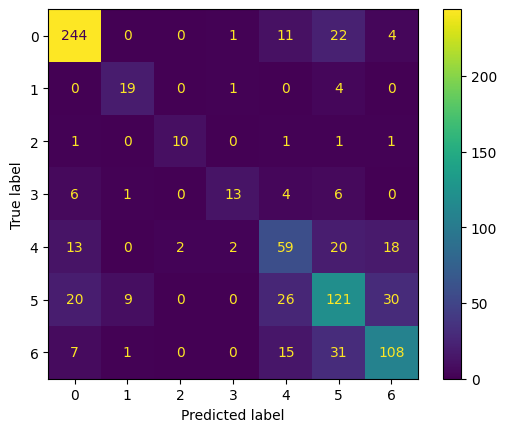


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false positives: ['neutral(5)']



In [36]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_iemo_reduced = SVC().set_params(**svm_best_model.get_params())
svm_emo_iemo_reduced.fit(X_train, y_train)
model_eval(svm_emo_iemo_reduced, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
98.40% for the train data
59.69% for the test data

Evaluation: accuracy_score
97.37% for the train data
65.02% for the test data

Evaluation: precision_score
98.11% for the train data
60.73% for the test data

Evaluation: recall_score
98.75% for the train data
62.26% for the test data

Evaluation: confusion_matrix of test predictions


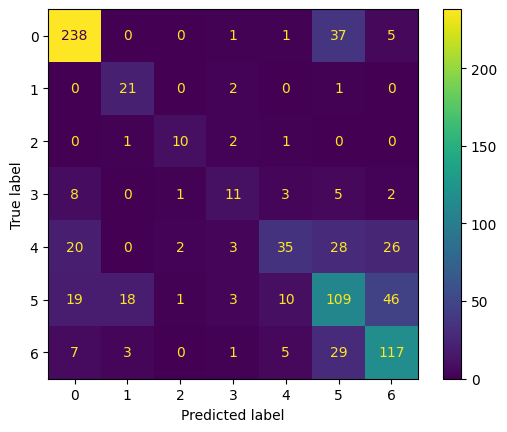


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['neutral(5)', 'sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['sadness(6)']

Label: sadness(6)
Hard cases of false positives: ['neutral(5)']



In [37]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_iemo_reduced = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_iemo_reduced.fit(X_train, y_train)
model_eval(rfc_emo_iemo_reduced, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
96.99% for the train data
63.39% for the test data

Evaluation: accuracy_score
95.62% for the train data
69.11% for the test data

Evaluation: precision_score
97.29% for the train data
71.78% for the test data

Evaluation: recall_score
96.74% for the train data
59.51% for the test data

Evaluation: confusion_matrix of test predictions


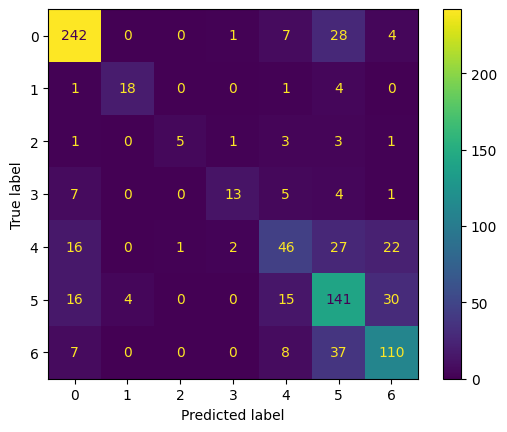


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['happiness(4)', 'neutral(5)']

Label: fear(3)
Hard cases of false negatives: ['anger(0)']

Label: happiness(4)
Hard cases of false negatives: ['neutral(5)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [38]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_iemo_reduced = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_iemo_reduced.fit(X_train, y_train)
model_eval(xgb_emo_iemo_reduced, X_train, X_test, y_train, y_test, confusion=True)

# 4) EmoDB + RAVDESS + IEMOCAP
## a) EmoDB + Ravdess + Iemocap with most important features from featurewiz 97

In [39]:
# get most important features (featurewiz 97)
df = pd.read_pickle('../results/df_prep_most_important97.pkl')
feat_most_imp97 = df.columns.to_list() 

# load data
df_emo_rav_iemo = pd.read_pickle('../results/df_prep_numerical_only_all_stats_emodb_ravdess_iemocap.pkl')

# check if there are any features in the saved set of most important features from emodb
mis_cols = list(set(feat_most_imp97) - set(df_emo_rav_iemo.columns.to_list()))
print(f'{mis_cols} are missing in the Iemocap/Ravdess feature set and are removed from the list.')
for feat in mis_cols:
    feat_most_imp97.remove(feat)
    
# select features    
df_emo_rav_iemo_most_imp97 = df_emo_rav_iemo[feat_most_imp97]

# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_rav_iemo_most_imp97, test_size=0.3)

['f0_avg_change_rate_median'] are missing in the Iemocap/Ravdess feature set and are removed from the list.
A snippet of the data:


rms_min  mfccs5_mean   zcr_max  duration_rising_pitch_max  \
3240 -0.099948    -0.979311  1.262751                  -1.138961   
546  -0.643464    -0.071618 -0.167671                   0.373555   
1903  0.468190     0.872950 -0.077594                   1.408435   
1574 -0.643789    -1.988810  0.365585                   0.353654   
3136 -0.046792    -0.219181 -0.131640                   3.119967   

      lpccs_local4_min  lfccs9_max       min  energy_median  lfccs0_median  \
3240          0.016163    0.070734  0.311413       0.511154       0.500579   
546           0.016163    1.756250  0.562220      -0.664089      -0.881446   
1903          0.016163   -0.139762  0.533063      -0.596592       0.125440   
1574          0.016163    1.260154  0.038029      -0.662554      -0.613271   
3136          0.016163    0.458978 -0.024216      -0.616539       0.275070   

      lpccs_global_median  lpc_global_mean  value_falling_energy_max  \
3240             0.029151        -0.225237                  0.135936   
546             -0.054492        -0.841747                  0.204471   
1903            -0.022367        -0.354008                  0.200588   
1574             0.759265        -0.565108                  0.204470   
3136             0.705972         0.766481                  0.204426   

      mfccs11_mean    f1_min  lpc_local3_var  lpccs_local0_var  lfccs9_median  \
3240     -0.323084 -0.454592       -0.022689         -0.540563       0.612144   
546      -1.660241 -1.355190       -0.022464          1.787418       0.496492   
1903      0.775175  0.565748       -0.022754         -0.728062       0.070186   
1574     -1.111778 -0.216745       -0.022197          2.006867      -0.136467   
3136      0.180729 -0.138253       -0.022733         -0.139270       0.296593   

      delta_mfccs0_min  value_falling_pitch_iqr  lpc_local1_mean  \
3240          0.861882                 0.997666        -0.413790   
546          -0.319327                -0.434506         0.810653   
1903          0.847008                -0.579589        -0.644648   
1574         -0.613244                -0.269764         0.599959   
3136         -0.109918                -0.293751        -0.432636   

      f1_avg_change_rate_var  threshold_entropy_var  mfccs3_max   f2_mean  \
3240               -0.634944              -0.702696    0.172054  0.653984   
546                 0.710518               1.237118    0.407414 -1.164742   
1903               -0.102266               0.106463   -0.495908 -2.035951   
1574               -0.400939               1.129254   -0.255822 -0.421786   
3136               -0.472406               0.277321    0.464401  0.653233   

      lfccs7_var  lfccs9_var  delta_mfccs5_median  mfccs4_max  energy_var  \
3240    0.899552    1.050186             0.160036   -0.410520   -0.397848   
546    -0.158405    0.007436            -0.044332    1.972706   -0.720235   
1903   -1.007872   -0.825769             0.261969    0.372013    0.361036   
1574    0.780163    0.016734            -0.044332    1.029358   -0.721212   
3136   -0.068091    0.584753             0.391385    0.009620   -1.181255   

      delta2_mfccs3_min  lpccs_local5_mean  shannon_entropy_mean  \
3240           0.045974          -0.016163              0.972729   
546            0.557817          -0.016163             -1.209773   
1903           0.588440          -0.016163              0.669812   
1574          -1.069671          -0.016163             -1.039115   
3136          -0.203300          -0.016163              0.290988   

      delta2_mfccs5_mean  delta_mfccs4_median   f3_mean  mfccs5_var  \
3240           -0.556007            -0.851522 -0.554399    0.703200   
546             0.025686            -0.153087 -0.974981    1.333206   
1903           -0.025100            -0.329547 -2.305957   -0.609110   
1574            0.028947            -0.153087 -0.017123    1.409186   
3136            0.278360             0.599460  0.459034   -0.018263   

      voiced_var  duration_rising_ener

There are 2680 entries with 96 columns in the training data.
There are 1149 entries with 96 columns in the testing data.


### SVM


Evaluation: f1_score
97.94% for the train data
62.93% for the test data

Evaluation: accuracy_score
97.46% for the train data
63.71% for the test data

Evaluation: precision_score
97.54% for the train data
63.69% for the test data

Evaluation: recall_score
98.37% for the train data
62.37% for the test data

Evaluation: confusion_matrix of test predictions


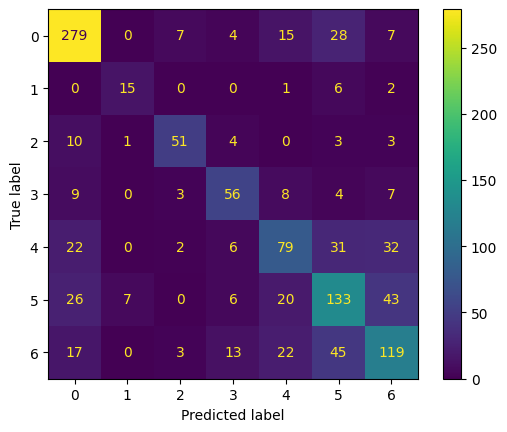


Hard cases for the model:

Label: boredom(1)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']



In [40]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_rav_iemo = SVC().set_params(**svm_best_model.get_params())
svm_emo_rav_iemo.fit(X_train, y_train)
model_eval(svm_emo_rav_iemo, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
94.62% for the train data
57.96% for the test data

Evaluation: accuracy_score
95.30% for the train data
60.05% for the test data

Evaluation: precision_score
92.69% for the train data
58.38% for the test data

Evaluation: recall_score
97.21% for the train data
62.85% for the test data

Evaluation: confusion_matrix of test predictions


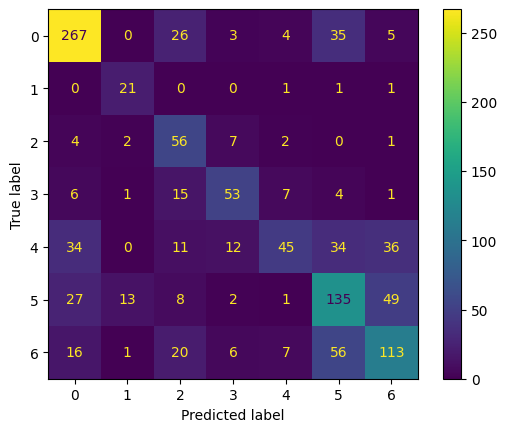


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']



In [41]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_rav_iemo = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_rav_iemo.fit(X_train, y_train)
model_eval(rfc_emo_rav_iemo, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
90.73% for the train data
58.55% for the test data

Evaluation: accuracy_score
88.51% for the train data
59.88% for the test data

Evaluation: precision_score
91.53% for the train data
61.53% for the test data

Evaluation: recall_score
90.40% for the train data
56.94% for the test data

Evaluation: confusion_matrix of test predictions


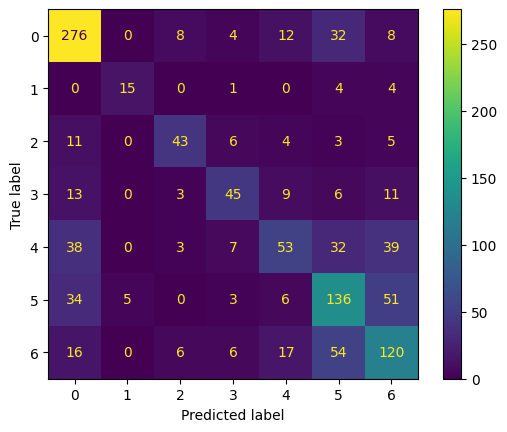


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: happiness(4)
Hard cases of false negatives: ['anger(0)', 'sadness(6)']

Label: neutral(5)
Hard cases of false negatives: ['sadness(6)']
Hard cases of false positives: ['sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['neutral(5)']



In [42]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_rav_iemo = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_rav_iemo.fit(X_train, y_train)
model_eval(xgb_emo_rav_iemo, X_train, X_test, y_train, y_test, confusion=True)

## b) EmoDB + Ravdess + Iemocap own feature selection

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (3829, 576)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#############################################

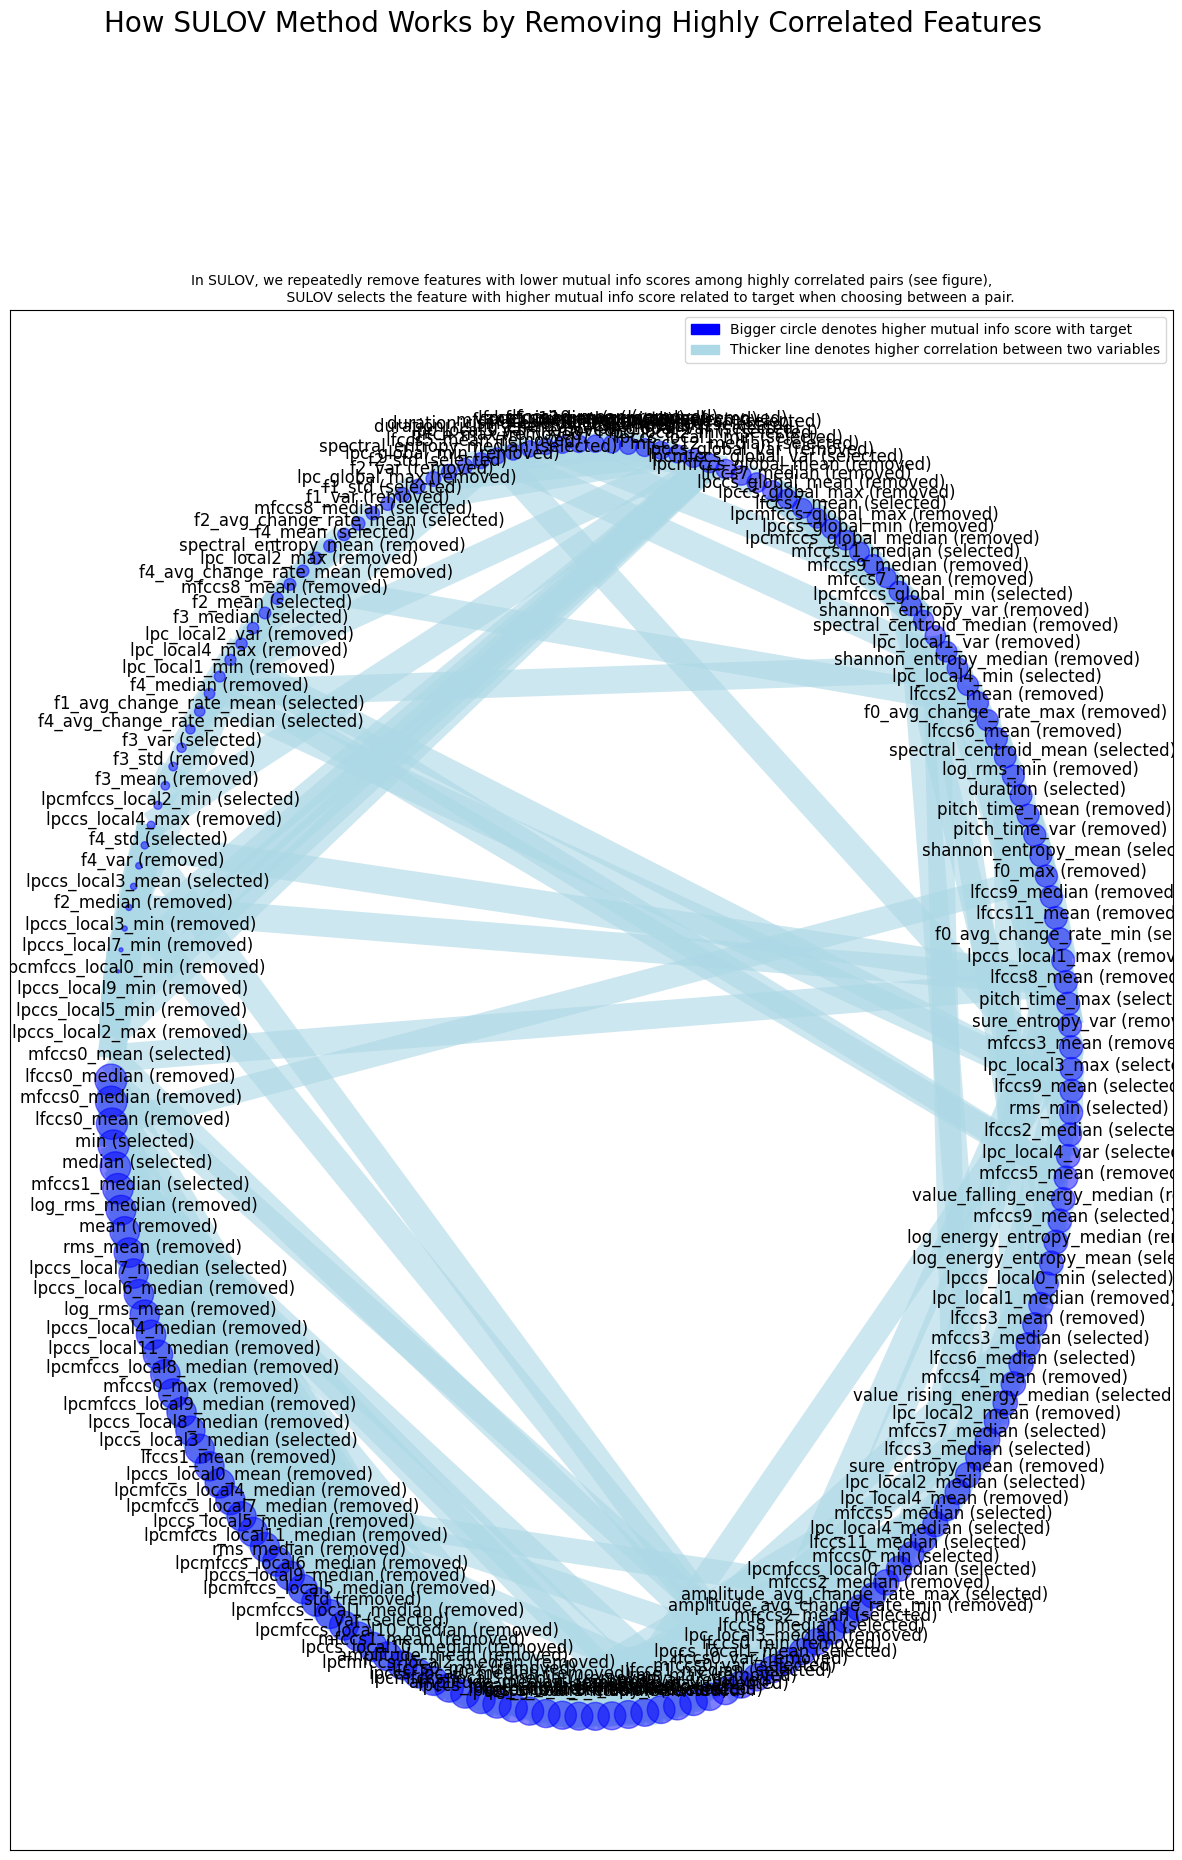

Time taken for SULOV method = 7 seconds
    Adding 0 categorical variables to reduced numeric variables  of 461
Finally 461 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 115 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
    Number of booster rounds = 100
            Time taken for regular XGBoost feature selection = 109 seconds
            Time taken for regular XGBoost feature selection = 89 seconds
            Time taken for regular XGBoost feature selection = 64 seconds
            Time taken for regular XGBoost feature selection = 42 seconds
            Time taken for regular XGBoost feature selection = 27 

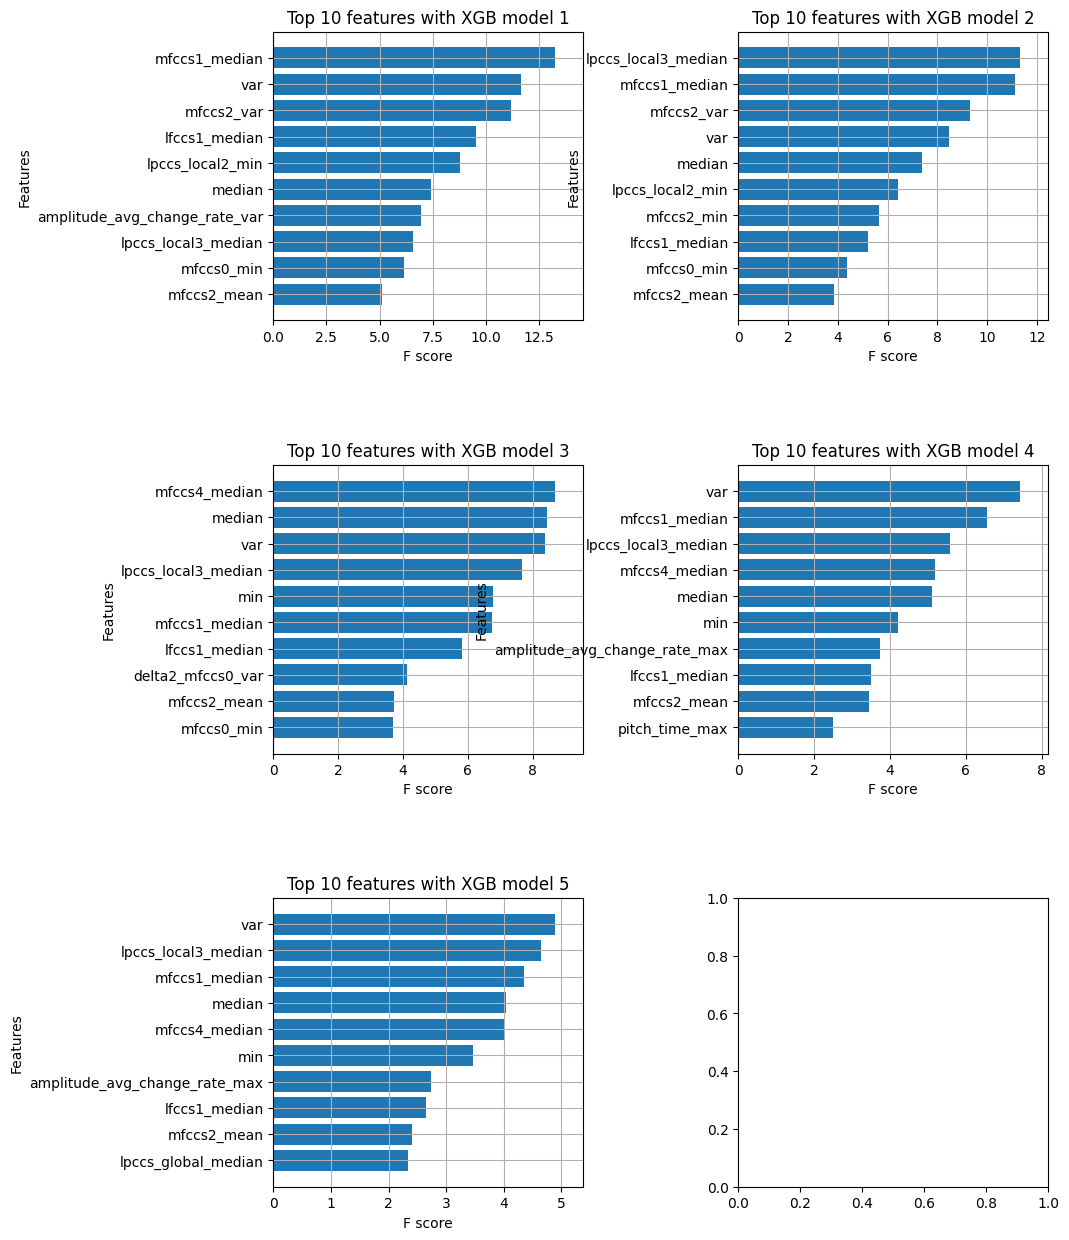

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 201 important features. Too many to print...
Total Time taken for featurewiz selection = 338 seconds
Output contains a list of 201 important features and a train dataframe


In [43]:
# automatic feature selection by using featurewiz package
selected_features_emo_rav_iemo, df_emo_rav_iemo_reduced = featurewiz(df_emo_rav_iemo, 'label', corr_limit=0.9, verbose=2, sep=",", 
                                                           header=0,test_data="", feature_engg="", category_encoders="")

In [44]:
# load train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df_emo_rav_iemo_reduced, test_size=0.3)

A snippet of the data:


mfccs2_var  amplitude_avg_change_rate_var  mfccs1_median  \
3240    1.290137                      -0.430667       0.157674   
546    -0.631185                      -0.473935      -1.105499   
1903   -0.970471                      -0.454097       0.986211   
1574    1.151111                      -0.437900      -1.648654   
3136    1.279654                      -0.328276       0.374680   

      pitch_time_median  mfccs2_mean  lfccs1_median    median       var  \
3240          -0.419596    -0.060347       0.611909 -0.146900 -0.301894   
546           -0.060440     0.234281      -0.318817 -0.525081 -0.339637   
1903           1.165244     0.199682       0.603900 -0.344827 -0.338869   
1574           0.382342    -0.601221      -1.508632 -0.516245 -0.274885   
3136           2.124466    -0.291476       0.047139 -0.385472 -0.296373   

      mfccs2_min  lpccs_local2_min  lpccs_global_median  lfccs4_var  \
3240   -0.171137          0.018426             0.029151    0.547167   
546     0.419012          0.018423            -0.054492    1.793998   
1903    0.785878          0.018428            -0.022367   -1.163805   
1574   -2.040491          0.018424             0.759265    0.999923   
3136   -1.564781          0.018424             0.705972    0.575393   

      mfccs0_min  value_rising_pitch_iqr  lpc_local3_mean  delta_mfccs0_var  \
3240    0.399253                0.997666        -0.398650         -0.398053   
546    -1.199446               -0.434506         0.446353         -0.318048   
1903    0.848711               -0.579589        -0.491892         -0.747024   
1574   -0.602876               -0.269764         0.426694          0.012095   
3136    0.297336               -0.293751        -0.472431         -0.299968   

        f2_std  mfccs2_max  f1_median  articulation_rate  lfccs1_min  \
3240 -0.448504    0.357381  -0.226089           0.653447   -0.044135   
546   0.030433    0.618846  -0.233334           1.046755   -0.419288   
1903 -1.079417   -0.001718  -0.773475          -0.829530    0.790196   
1574  1.484711    0.201010   0.971889          -0.096152   -0.419287   
3136 -0.457519   -0.456095   0.937754           0.115447    0.446074   

      amplitude_var  duration_rising_pitch_iqr    f1_std  mfccs5_median  \
3240      -0.482163                  -0.158387 -0.422895      -1.136350   
546       -0.513898                  -0.740617  0.349112      -0.931428   
1903      -0.503063                  -0.376724 -1.034180       0.781497   
1574      -0.317213                  -0.231166 -0.009874      -1.187070   
3136      -0.301215                  -0.413113  0.704465      -0.494945   

      spectral_entropy_var   f0_mean  mfccs1_max  lfccs1_var   rms_min  \
3240             -0.418856  1.634057    0.033026    0.029598 -0.099948   
546               1.397970 -0.620905    1.185674    2.332695 -0.643464   
1903             -0.657405 -0.679251    0.718278   -0.937601  0.468190   
1574              1.760678 -0.057490    0.097078    2.476933 -0.643789   
3136             -0.478910  0.172673   -1.069608   -0.368616 -0.046792   

      mfccs9_mean  lpc_local4_median  mfccs5_min  lpc_global_mean  \
3240    -0.679587           0.560992   -0.252659        -0.225237   
546     -1.102832          -0.023591   -0.185858        -0.841747   
1903     0.328141           0.328665    0.333016        -0.354008   
1574    -1.503918          -0.624155   -2.105440        -0.565108   
3136     0.222912           0.530739   -0.417017         0.766481   

      delta2_mfccs0_var  delta2_mfccs3_var   zcr_max  zcr_median  voiced_mean  \
3240          -0.030906           0.022696  1.262751    0.131964     1.243806   
546           -0.458686          -0.706037 -0.167671   -1.205873    -0.801047   
1903          -0.785834          -0.712186 -0.077594   -0.265333     0.468656   
1574          -0.321216          -0.575550  0.365585   -0.670739    -0.634156   
3136          -0.037308          -0.480200 -0.131640    0.537369     0.613102   

      lfccs8_min  lfccs11

There are 2680 entries with 201 columns in the training data.
There are 1149 entries with 201 columns in the testing data.


### SVM


Evaluation: f1_score
99.39% for the train data
69.02% for the test data

Evaluation: accuracy_score
99.10% for the train data
69.02% for the test data

Evaluation: precision_score
99.35% for the train data
69.84% for the test data

Evaluation: recall_score
99.44% for the train data
68.29% for the test data

Evaluation: confusion_matrix of test predictions


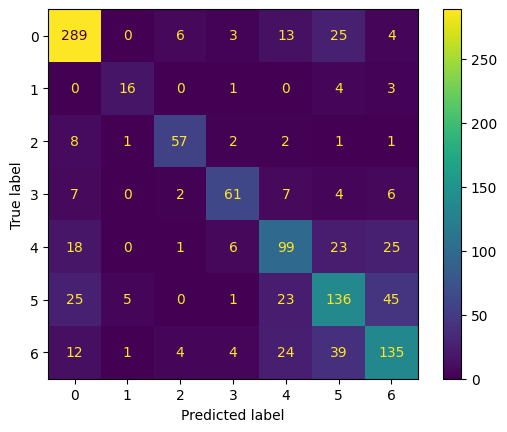


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: sadness(6)
Hard cases of false positives: ['neutral(5)']



In [45]:
svm_best_model = load_model('SVC', 'f1_macro', name_spec='final')
svm_emo_rav_iemo_reduced = SVC().set_params(**svm_best_model.get_params())
svm_emo_rav_iemo_reduced.fit(X_train, y_train)
model_eval(svm_emo_rav_iemo_reduced, X_train, X_test, y_train, y_test, confusion=True)

### Random Forest


Evaluation: f1_score
95.22% for the train data
61.37% for the test data

Evaluation: accuracy_score
95.67% for the train data
62.66% for the test data

Evaluation: precision_score
93.53% for the train data
61.38% for the test data

Evaluation: recall_score
97.46% for the train data
67.07% for the test data

Evaluation: confusion_matrix of test predictions


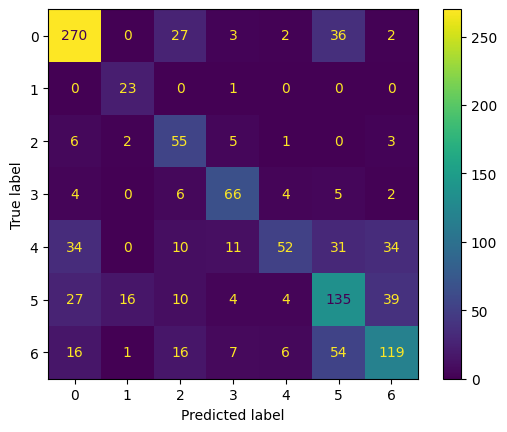


Hard cases for the model:

Label: boredom(1)
Hard cases of false positives: ['neutral(5)']

Label: disgust(2)
Hard cases of false positives: ['anger(0)']

Label: neutral(5)
Hard cases of false positives: ['sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [46]:
rfc_best_model = load_model('RandomForestClassifier', 'f1_macro', name_spec='final')
rfc_emo_rav_iemo_reduced = RandomForestClassifier().set_params(**rfc_best_model.get_params())
rfc_emo_rav_iemo_reduced.fit(X_train, y_train)
model_eval(rfc_emo_rav_iemo_reduced, X_train, X_test, y_train, y_test, confusion=True)

### XGB


Evaluation: f1_score
93.56% for the train data
64.56% for the test data

Evaluation: accuracy_score
91.79% for the train data
65.01% for the test data

Evaluation: precision_score
94.31% for the train data
67.75% for the test data

Evaluation: recall_score
93.09% for the train data
62.77% for the test data

Evaluation: confusion_matrix of test predictions


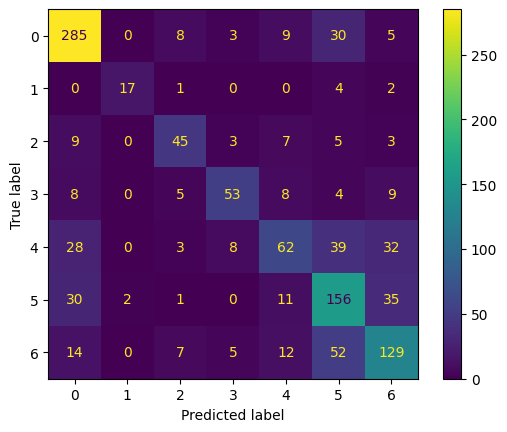


Hard cases for the model:

Label: happiness(4)
Hard cases of false negatives: ['neutral(5)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']



In [47]:
xgb_best_model = load_model('XGBClassifier', 'f1_macro', name_spec='final')
xgb_emo_rav_iemo_reducedd = XGBClassifier().set_params(**xgb_best_model.get_params())
xgb_emo_rav_iemo_reducedd.fit(X_train, y_train)
model_eval(xgb_emo_rav_iemo_reducedd, X_train, X_test, y_train, y_test, confusion=True)